<a href="https://colab.research.google.com/github/zer0Percent/Mineria-Informacion-Social/blob/T3/Trend_analysis_Probabilistic_and_clustering_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Álvaro Domínguez Calvo <br>
dominguezcalvoalvaro@icloud.com

In [ ]:
! pip install -U spacy

     |████████████████████████████████| 6.0 MB 5.4 MB/s 
     |████████████████████████████████| 653 kB 71.3 MB/s 
     |████████████████████████████████| 451 kB 84.3 MB/s 
     |████████████████████████████████| 10.1 MB 72.7 MB/s 
     |████████████████████████████████| 42 kB 1.5 MB/s 
     |████████████████████████████████| 181 kB 64.9 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [ ]:
! pip install tweepy

In [ ]:
import pandas as pd
import numpy as np
import spacy
import tweepy
import seaborn as sns
import os
import subprocess
from matplotlib import pyplot as plt
sns.set() 

import json
from datetime import date
from argparse import Namespace
import csv
import ast

In [ ]:
args_loading = Namespace(
    drive_base_url = 'https://drive.google.com/uc?id=',
    path_csv_named_entities = {'covid': '/content/full_twitter_dataset/covid.csv',
                               'la palma': '/content/full_twitter_dataset/la palma.csv'},
                         
    twitter_google_drive_id = '1jw3-sblauIiIYu2_k-3gA1lMCcuGI1ok',

    dataset_drive_ids = ['1roImmYGIJeHZxivfeYT2r37QOIp_iov8',
                         '1QIRjhNxdT-EIfPw0PSpCp2Ks5EgGtB1N',
                         '187rLuiW_GFl6wF5WcbixqVKvAVBzi8ok',
                         '1jiZy71Whk0pvSNcEuCDJPNrLx6QwZ59p'],
    rows_tweet = ["created_at",
                          "id",
                          "lang",
                          "user_id",
                          "text",
                          "retweet_count",
                          "favorite_count",
                          "hashtags",
                          "symbols",
                          "user_mentions",
                          "urls",
                          "media_urls",
                          "possibly_sensitive",
                          "geo",
                          "coordinates",
                          "in_reply_to_status_id",
                          "in_reply_to_status_id_str",
                          "in_reply_to_user_id",
                          "in_reply_to_user_id_str",
                          "in_reply_to_screen_name"
                          ],
    vcluster_path = "/content/cluto-2.1.1/Linux/vcluster",
    scluster_path = "/content/cluto-2.1.1/Linux/scluster",

    limit_tweets = 15000,
    regex_tweets = {
        'regexHashtagsMentions': r'[a-zA-Z#@]*[a-zA-Z#@]',
        'regexOnlyWords': r'(?<!#)(?<!@)\b[a-zA-Z]+'
    },

    cluto_columns = ['Cluster id', 'Size', 'ISim', 'ISdev', 'ESim', 'ESdev']
)

In [ ]:
userids = {
    '1': {'consumer_key': 'auTPnLWI32x4j2CAVOvxuwjRW', 
          'consumer_secret': 'srqesOexSBLvavje1FrD4Q8FDkhwW0mOhw4Cgd8H0w1CraKcxB', 
          'access_token': '1054479724653830146-4HgajMVb3OGI7XnOmcvJfQxRCVot99', 
          'access_token_secret': 'NQuOziOOktZ17BDExM0wBVsJjF8OQcd467WHsFoJtAkpq'},
}

In [ ]:
userid = 1
consumer_key = userids[str(userid)]['consumer_key']
consumer_secret = userids[str(userid)]['consumer_secret']
access_key = userids[str(userid)]['access_token']
access_secret = userids[str(userid)]['access_token_secret']

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

# 1. Dataset processing

##1.1 Data loading

Unzip the dataset and read it as a Pandas Dataframe.

In [ ]:
! unzip -q /content/raw_2022-01-17_full_twitter_dataset.zip -d /content

the next functon will help to generate dataframes from a given CSV

In [ ]:
# Function to generate a dataframe given its CSV file
def generate_dataframe_from_csv(path_csv):
  dataframe = pd.read_csv(path_csv,
                          dtype={'id_tweet': 'Int64', 'user_id': 'Int64'},
                          na_values='0',
                          engine="python")
  dataframe = dataframe.drop(columns=['Unnamed: 0'])
  return dataframe

Next, it will be generated the dataframes for the named entities of `covid` and `la palma`. Each daataframe has a column `id_tweet`-

In [ ]:
covid_dataframe =  generate_dataframe_from_csv(
    args_loading.path_csv_named_entities['covid']
)

In [ ]:
la_palma_dataframe = generate_dataframe_from_csv(
    args_loading.path_csv_named_entities['la palma']
)

Only spanish and english languages will be considered.

In [ ]:
spanish_covid_df = covid_dataframe[covid_dataframe['language'] == 'es']
english_covid_df = covid_dataframe[covid_dataframe['language'] == 'en']

spanish_palma_df = la_palma_dataframe[la_palma_dataframe['language'] == 'es']
english_palma_df = la_palma_dataframe[la_palma_dataframe['language'] == 'en']

However, the retrieval of the dataset was done in december. It is expected that some tweets are not available anymore. Thus, it will be retrieved the tweets again but using the `id_tweet`. <br>
The next functions will help to do so.

In [ ]:
def get_media_urls(medias):
  return [media['media_url'] for media in medias]

In [ ]:
def write_tweets_in(api, csv_writer, tweets_ids):
  num_tweets_written = 0

  while True:
    try:
      tweets = api.statuses_lookup(tweets_ids,
                                   tweet_mode='extended')
      for tweet in tweets:
        csv_writer.writerow([tweet.created_at,
                             tweet.id,
                             tweet.lang,
                             tweet.user.id,
                             tweet.full_text,
                             tweet.retweet_count,
                             tweet.favorite_count,
                             [hashtag['text'] for hashtag in tweet.entities['hashtags']],
                             tweet.entities['symbols'],
                             [mention['id_str'] for mention in tweet.entities['user_mentions']],
                             [url['url'] for url in tweet.entities['urls']],
                             get_media_urls(tweet.entities['media']) if 'media' in tweet.entities.keys() else [],
                             tweet.coordinates,
                             tweet.in_reply_to_status_id,
                             tweet.in_reply_to_status_id_str,
                             tweet.in_reply_to_user_id,
                             tweet.in_reply_to_user_id_str,
                             tweet.in_reply_to_screen_name
                             ])
      num_tweets_written = len(tweets)
    except Exception as e:
      continue
    break
    
  return num_tweets_written

In [ ]:
def persist_csv_tweets(path_csv, rows_tweet, tweet_ids, step = 100):
  start = 0
  end = step
  print("Writting tweets in {path}.".format(path = path_csv ))
  total_written_tweets = 0

  with open(path_csv, 'w') as fw:
    csv_writer = csv.writer(fw)
    csv_writer.writerow(rows_tweet)

    while len(tweet_ids[start:end]) > 0:
      tweets = tweet_ids[start:end]
      count_written = write_tweets_in(api,
                                      csv_writer,
                                      tweets)
      total_written_tweets += count_written

      start = start + step
      end = end + step
  
  print("End writting tweets in {path}.".format(path = path_csv ))

For the four dataframes it will be generated a CSV file with the tweet information.

In [ ]:
spanish_palma_csv_path = '/content/spanish_palma.csv'
english_palma_csv_path = '/content/english_palma.csv'
spanish_covid_csv_path = '/content/spanish_covid.csv'
english_covid_csv_path = '/content/english_covid.csv'

In [ ]:
persist_csv_tweets(
    spanish_palma_csv_path,
    args_loading.rows_tweet,
    list(spanish_palma_df['id_tweet'])
)


Writting tweets in /content/spanish_palma.csv.
End writting tweets in /content/spanish_palma.csv.
Writting tweets in /content/english_palma.csv.
End writting tweets in /content/english_palma.csv.


In [ ]:
persist_csv_tweets(
    english_palma_csv_path,
    args_loading.rows_tweet,
    list(english_palma_df['id_tweet'])
)

Writting tweets in /content/english_palma.csv.
End writting tweets in /content/english_palma.csv.


For the `covid` named entity the CSV files are generated below.

In [ ]:
persist_csv_tweets(
    spanish_covid_csv_path,
    args_loading.rows_tweet,
    list(spanish_covid_df['id_tweet'])
)

Writting tweets in /content/spanish_covid.csv.
End writting tweets in /content/spanish_covid.csv.


In [ ]:

persist_csv_tweets(
    english_covid_csv_path,
    args_loading.rows_tweet,
    list(english_covid_df['id_tweet'])
)

Writting tweets in /content/english_covid.csv.
End writting tweets in /content/english_covid.csv.


Lastly, given the CSV files, all the dataframes will be loaded

In [ ]:
!gdown --id 1-oTU-dJAU8L2k1lxmOowjQDF4Alf7Jpo

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1-oTU-dJAU8L2k1lxmOowjQDF4Alf7Jpo 



In [ ]:
# Uncomment to download them directly from Google Drive

! gdown https://drive.google.com/uc?id=1ip2fDPHw2hKzwAvmd6fY6P7BaN7MohrV
! gdown https://drive.google.com/uc?id=1BnMGXqD6YjWJbN6g5gpvUFXhUdP6VlSm
! gdown https://drive.google.com/uc?id=12kDq-rtEzvZOj9IvZpeZ9mosei7MfP80
! gdown https://drive.google.com/uc?id=1A6mXGRntr4DDP5rKNLm3-xiqIs7SV-I4

Downloading...
From: https://drive.google.com/uc?id=1ip2fDPHw2hKzwAvmd6fY6P7BaN7MohrV
To: /content/english_palma.csv
100% 1.14M/1.14M [00:00<00:00, 103MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BnMGXqD6YjWJbN6g5gpvUFXhUdP6VlSm
To: /content/spanish_palma.csv
100% 9.18M/9.18M [00:00<00:00, 16.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=12kDq-rtEzvZOj9IvZpeZ9mosei7MfP80
To: /content/spanish_covid.csv
100% 30.9M/30.9M [00:00<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=1A6mXGRntr4DDP5rKNLm3-xiqIs7SV-I4
To: /content/english_covid.csv
100% 33.0M/33.0M [00:00<00:00, 141MB/s] 


In [ ]:
spanish_covid_df = pd.read_csv(spanish_covid_csv_path) 
english_covid_df = pd.read_csv(english_covid_csv_path)

spanish_palma_df = pd.read_csv(spanish_palma_csv_path) 
english_palma_df = pd.read_csv(english_palma_csv_path) 

## 1.1 Preprocessing pipeline

Each tweet is preprocessed by tokenizing and normalizing its tokens.
However, the dataframes will me modified by adding three new columns to store the hashtags, mentions and URLs for each tweet.

This step consists in retrieving the hashtags, mentions and URLs for each tweet and sotre this information y three columns respectively.

### 1.1.1 Preprocessing: Tokenization and normalization

The tokenization of each tweet must be executed in function of the language considered since the the definition of token may vary. That is, determining what is the delimeter to break up the text into tokens will vary in function of the language of the text itself. Spacy provides tokenizers for many languages.<br>

The normalization process depends on the document language too. Spacy has trained models to execute common NLP tasks like PoS tagging, tokenization, NER, etc. In this work, the normalization step consists in, for each tweet: <br>
1.   Remove all the links
2.   Remove all the numbers
3.   Lowercase all the tokens
4.   Lemmatize each word
5.   Given the lemma of each word, stemmize them



It will be loaded the Spacy trained models for the languages of english and spanish.

In [ ]:
! python -m spacy download en_core_web_lg

     |████████████████████████████████| 777.4 MB 5.8 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
! python -m spacy download es_core_news_lg

     |██████████████████████████████▋ | 544.5 MB 109.2 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 569.1 MB 19 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')


Since Spacy only provides the lemmatization module, the Porter stemmer algorithm will be used for the stemmization step.

In [ ]:
from nltk.stem import SnowballStemmer

In [ ]:
model_en = spacy.load('en_core_web_lg')
model_es = spacy.load('es_core_news_lg')

stemmer_en = SnowballStemmer(language='english')
stemmer_es = SnowballStemmer(language='spanish')

Next, the spanish and english dataframes will be modified to store the tokens, the lemmatized tokens and its PoS tags. The function `process` will handle the preprocessing steps described above.

In [ ]:
def is_url(token):
  return token.startswith('http')


def is_special_character(token):
  return token.startswith('/')

# Remove all the links
# Remove all the numbers
# Lemmatize each word
# Given the lemma of each word, stemmize them
def process_token(spacy_token, stemmer):

  processed_token = spacy_token.text
  if not is_url(spacy_token.text) and not is_special_character(spacy_token.text) and not spacy_token.text.isnumeric():
    
    lemma = spacy_token.lemma_.lower()
    stem = stemmer.stem(lemma)

    processed_token = stem
  return processed_token


TODO: Write the code to download the new csv files

For each token, the column `normalized` will store an array of tuples of tokens in the form: `(raw_token, lemma, processed_token(raw_token), PoS_tag, entity_type, entity_id)`. The two last components of the tuple corresponds named entity information (the type of named entity and the id of it).

In [ ]:
spanish_covid_df['normalized'] = spanish_covid_df['text'].apply(lambda tweet: [(word.text, word.lemma_, process_token(word, stemmer_es), word.pos_, word.ent_type_, word.ent_id_) for word in model_es(tweet)])
english_covid_df['normalized'] = english_covid_df['text'].apply(lambda tweet: [(word.text, word.lemma_, process_token(word, stemmer_es), word.pos_, word.ent_type_, word.ent_id_) for word in model_en(tweet)])

spanish_palma_df['normalized'] = spanish_palma_df['text'].apply(lambda tweet: [(word.text, word.lemma_, process_token(word, stemmer_es), word.pos_, word.ent_type_, word.ent_id_) for word in model_es(tweet)])
english_palma_df['normalized'] = english_palma_df['text'].apply(lambda tweet: [(word.text, word.lemma_, process_token(word, stemmer_es), word.pos_, word.ent_type_, word.ent_id_) for word in model_en(tweet)])


Next, it will be stored the processed tweets in CSV files

In [ ]:
spanish_palma_normalized_csv_path = '/content/spanish_palma_normalized.csv'
english_palma_normalized_csv_path = '/content/english_palma_normalized.csv'
spanish_covid_normalized_csv_path = '/content/spanish_covid_normalized.csv'
english_covid_normalized_csv_path = '/content/english_covid_normalized.csv'

In [ ]:
# Uncomment to retrieve the normalized tweets
#COVID
! gdown https://drive.google.com/uc?id=1Y2jdWuh0oJQsPdrdzX2r55k4GCzAeDlh
! gdown https://drive.google.com/uc?id=1eOD1wHTcGsCHZcPxFcdMGtGzu5Lu0H4N

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1Y2jdWuh0oJQsPdrdzX2r55k4GCzAeDlh 

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1eOD1wHTcGsCHZcPxFcdMGtGzu5Lu0H4N 



In [ ]:
#LA PALMA 
! gdown https://drive.google.com/uc?id=1lgyPx_btfcypLlpoLzWrf_9qyx52UEuU
! gdown https://drive.google.com/uc?id=1mnrW82lHRTC738uRx1_moWU_MJARTH04

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1lgyPx_btfcypLlpoLzWrf_9qyx52UEuU 

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1mnrW82lHRTC738uRx1_moWU_MJARTH04 



In [ ]:
spanish_palma_normalized_csv_path = '/content/drive/MyDrive/DataSets/NormalizedTwitter/spanish_palma_normalized.csv' 
english_palma_normalized_csv_path = '/content/drive/MyDrive/DataSets/NormalizedTwitter/english_palma_normalized.csv'
spanish_covid_normalized_csv_path = '/content/drive/MyDrive/DataSets/NormalizedTwitter/spanish_covid_normalized.csv'
english_covid_normalized_csv_path = '/content/drive/MyDrive/DataSets/NormalizedTwitter/english_covid_normalized.csv'

In [ ]:
from ast import literal_eval
def literal(x):
  try:
    return literal_eval(x)
  except Exception as e:
    return []

In [ ]:
# Uncomment to read the normalized tweets
spanish_covid_df = pd.read_csv(
    spanish_covid_normalized_csv_path,
    dtype={'id': 'Int64'},
    engine="python"
)
spanish_covid_df['normalized'] = spanish_covid_df['normalized'].apply(lambda tweet: literal(tweet))
spanish_covid_df = spanish_covid_df.drop(labels=[103831, 103832], axis=0)

english_covid_df = pd.read_csv(
    english_covid_normalized_csv_path,
    dtype={'id': 'Int64'},
    engine="python"
)
english_covid_df['normalized'] = english_covid_df['normalized'].apply(lambda tweet: literal(tweet))
english_covid_df = english_covid_df.drop(labels=[21204, 21203], axis=0)

spanish_palma_df = pd.read_csv(
    spanish_palma_normalized_csv_path,
    dtype={'id': 'Int64'},
    engine="python"
)
spanish_palma_df['normalized'] = spanish_palma_df['normalized'].apply(lambda tweet: literal(tweet))

english_palma_df = pd.read_csv(
    english_palma_normalized_csv_path,
    dtype={'id': 'Int64'},
    engine="python"
)
english_palma_df['normalized'] = english_palma_df['normalized'].apply(lambda tweet: literal(tweet))


In [ ]:
spanish_covid_df.to_csv(spanish_covid_normalized_csv_path, index=False)
english_covid_df.to_csv(english_covid_normalized_csv_path, index=False)

spanish_palma_df.to_csv(spanish_palma_normalized_csv_path, index=False)
english_palma_df.to_csv(english_palma_normalized_csv_path, index=False)

### 1.1.2 Feature selection: Vocabulary definition

The vocabulary will be built under the assumption that there will be words that are relevant in methods that relies on document vector representation. Defining which features are relevant is not a trivial task and statistical tests must be considered like the chi-squared test. However, most of them relies of the assumption that a target label y exists.
The proper word choice for building the vocabulary will rely on a frequestist fashion by weighting the words in terms of $TF−IDF$ representation.
<br>
For the vocabulary definition it will be considered the text processing executed by the `process` function for each token of each tweet. The dataframes will be extended with a column `processed_tweet` which is a string of the processed tokens separated by whitespaces. The function `untokenize` performs this operation.



In [ ]:
def untokenize(tokens):
  return " ".join(tokens)

Extend the dataframes with `processed_tweet` column

In [ ]:
spanish_covid_df['processed_tweet'] = spanish_covid_df['normalized'].apply(lambda tweet: untokenize([token_info[2] for token_info in tweet]))
english_covid_df['processed_tweet'] = english_covid_df['normalized'].apply(lambda tweet: untokenize([token_info[2] for token_info in tweet]))

spanish_palma_df['processed_tweet'] = spanish_palma_df['normalized'].apply(lambda tweet: untokenize([token_info[2] for token_info in tweet]))
english_palma_df['processed_tweet'] = english_palma_df['normalized'].apply(lambda tweet: untokenize([token_info[2] for token_info in tweet]))

In [ ]:
spanish_covid_df['processed_tweet']

0         @ddanielaff hol daniel com anda ? pobr tu madr...
1         rt @asuperbi : boric goz sueld de diput por mo...
2         📌 no tu pierd el prueb de covid-19 y anticuerp...
3         rt @philamellows : no par hast hac del cov uno...
4         rt @josefina_delaf : nuestr cam de cnn capt ot...
                                ...                        
120106                        😂 😂 😂 https://t.co/NohgD4yGIX
120107    hab entrar a refugi despues de much tiemp , yo...
120108    rt @dolom : por favor por dios y tod el sant ,...
120109    rt @carlosloret : orgull en @latinus_us . prem...
120110    alert panam covid-19 \n 📢 447 cas nuev \n 📢 48...
Name: processed_tweet, Length: 120109, dtype: object

Next, the TF-IDF matrix will be built for each dataframe.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

It will be stored all the TF-IDF in the folder `tfIdfMatrices`.

In [ ]:
! mkdir tfIdfMatrices

Build folders for each type of normalization (with no normalization and with the normalization defined in `process_token` function)

In [ ]:
! mkdir tfIdfMatrices/raw
! mkdir tfIdfMatrices/normalized

!mkdir tfIdfMatrices/raw/palma
!mkdir tfIdfMatrices/raw/covid

!mkdir tfIdfMatrices/normalized/palma
!mkdir tfIdfMatrices/normalized/covid

In [ ]:
def compute_tfidf_matrix(corpus,
                         max_df=0.01,
                         min_df=0.0025,
                         norm='l2',
                         regex = args_loading.regex_tweets['regexOnlyWords'],
                         limit_tweets = args_loading.limit_tweets):

  vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    norm=norm,
    token_pattern=regex
  )
  tfidf_matrix = vectorizer.fit_transform(corpus[:limit_tweets])
  
  return vectorizer.get_feature_names_out(), tfidf_matrix

def mean_weights_per_term(tfidf_matrix):
  return np.asarray(tfidf_matrix.mean(axis=0)).ravel().tolist()

def compute_sorted_dataframe(feature_names, weights_per_term, ascending=False):
  weights_df = pd.DataFrame({'term': feature_names, 'weight': weights_per_term})
  return weights_df.sort_values(by='weight', ascending=ascending)

For the `covid` dataset, the TF-IDF matrices for the two considered languages are cmputed below.

In [ ]:
corpus_spanish_covid_normalized = list(spanish_covid_df['processed_tweet'])
corpus_spanish_covid_raw = list(spanish_covid_df['text'])

# Raw TF-IDF
print("Spanish COVID dataframe: raw TF-IDF")
features_spanish_covid_raw, tfidf_spanish_covid_raw = compute_tfidf_matrix(
    corpus_spanish_covid_raw,
    max_df=0.01,
    min_df=0.0025,
    norm='l2'
)
print(features_spanish_covid_raw[:150])
mean_weights_covid_spanish_raw = mean_weights_per_term(tfidf_spanish_covid_raw)
df_weights_spanish_covid_raw = compute_sorted_dataframe(features_spanish_covid_raw, mean_weights_covid_spanish_raw)
print()
#Normalized TF-IDF
print("Spanish COVID dataframe: normalized TF-IDF")
features_spanish_covid_normalized, tfidf_spanish_covid_normalized = compute_tfidf_matrix(
    corpus_spanish_covid_normalized,
    max_df=0.1,
    min_df=0.0025,
    norm='l2'
)
print(features_spanish_covid_normalized[:150])
mean_weights_covid_spanish_normalized = mean_weights_per_term(tfidf_spanish_covid_normalized)
df_weights_spanish_covid_normalized = compute_sorted_dataframe(features_spanish_covid_normalized, mean_weights_covid_spanish_normalized)

Spanish COVID dataframe: raw TF-IDF
['absolutamente' 'ac' 'acaba' 'acompa' 'activos' 'acuerdo' 'adem'
 'adolescente' 'adultos' 'adversos' 'afectados' 'ah' 'aire' 'alemania'
 'alerta' 'algo' 'alguien' 'algunos' 'all' 'alto' 'am' 'amigos' 'amlo'
 'amp' 'ampliaremos' 'an' 'andaluc' 'ant' 'antes' 'anti' 'antivacunas'
 'anunci' 'aparte' 'aplicar' 'aqu' 'are' 'argentina' 'art' 'astrazeneca'
 'at' 'atenci' 'atender' 'atropellado' 'aumento' 'aunque' 'austria'
 'autoridades' 'ave' 'ayuda' 'b' 'baja' 'balance' 'bar' 'barcelona'
 'bares' 'batallita' 'be' 'biacsics' 'bien' 'billete' 'bioseguridad'
 'breve' 'brote' 'buen' 'buena' 'bueno' 'but' 'ca' 'caf' 'campa' 'canse'
 'casa' 'catalu' 'causa' 'centro' 'centros' 'cepa' 'chile' 'cient'
 'cierto' 'cifras' 'ciudad' 'cl' 'claro' 'claudia' 'cobro' 'cofundadora'
 'colombia' 'com' 'comercial' 'compa' 'completa' 'completo' 'comunidad'
 'comunidades' 'confirm' 'confirma' 'confirman' 'considerarlos' 'contacto'
 'contactos' 'contagiados' 'contagio' 'contin' 

In [ ]:
len(features_spanish_covid_normalized)

724

In [ ]:
df_weights_spanish_covid_raw

,term,weight
96,datos,0.005495
39,bien,0.005454
354,poblaci,0.005274
445,ten,0.005171
292,muertes,0.005109
...,...,...
30,arremete,0.001148
186,gimnasio,0.001079
350,pidan,0.001042
68,cometiendo,0.001018


In [ ]:
df_weights_spanish_covid_normalized

,term,weight
422,seri,0.006146
435,sueld,0.005649
400,reduc,0.005401
57,bio,0.005286
56,bien,0.005279
...,...,...
261,liberum,0.001204
126,delic,0.001124
38,arremet,0.001105
90,comet,0.001082


Storing the `tfidf_spanish_covid_raw.mat` file in order to use it with the CLUTO clustering tool.

In [ ]:
path_tfidf_spanish_covid_txt = 'tfIdfMatrices/raw/covid/tfidf_spanish_covid.txt'
np.savetxt(path_tfidf_spanish_covid_txt, tfidf_spanish_covid_raw.toarray(), delimiter='\t', fmt='%.6f')

Then it will be written the number of rows and columns as the first line of the `.mat` file.

In [ ]:
with open(path_tfidf_spanish_covid_txt, 'r') as ff, open('tfIdfMatrices/raw/covid/tfidf_spanish_covid.mat', 'w') as write_obj:
  row_column = '{rows}  {columns}\n'.format(rows = tfidf_spanish_covid_raw.shape[0],
                                            columns = tfidf_spanish_covid_raw.shape[1])
  lines = ff.readlines()
  write_obj.write(row_column)
  write_obj.writelines(lines)

Next, we store the normalized TF-IDF matrix

In [ ]:
path_tfidf_spanish_covid_txt = 'tfIdfMatrices/normalized/covid/tfidf_spanish_covid.txt'
np.savetxt(path_tfidf_spanish_covid_txt, tfidf_spanish_covid_normalized.toarray(), delimiter='\t', fmt='%.6f')
with open(path_tfidf_spanish_covid_txt, 'r') as ff, open('tfIdfMatrices/normalized/covid/tfidf_spanish_covid.mat', 'w') as write_obj:
  row_column = '{rows}  {columns}\n'.format(rows = tfidf_spanish_covid_normalized.shape[0],
                                            columns = tfidf_spanish_covid_normalized.shape[1])
  lines = ff.readlines()
  write_obj.write(row_column)
  write_obj.writelines(lines)

For the `english_covid` data set the TF-IDF matrices are computed below.

In [ ]:
corpus_english_covid_normalized = list(english_covid_df['processed_tweet'])
corpus_english_covid_raw = list(english_covid_df['text'])

# Raw TF-IDF
print("English COVID dataframe: raw TF-IDF")
features_english_covid_raw, tfidf_english_covid_raw = compute_tfidf_matrix(
    corpus_english_covid_raw,
    max_df=0.01,
    min_df=0.0025,
    norm='l2'
)

print(features_english_covid_raw[:150])
mean_weights_covid_english_raw = mean_weights_per_term(tfidf_english_covid_raw)
df_weights_english_covid_raw = compute_sorted_dataframe(features_english_covid_raw, mean_weights_covid_english_raw)

print()
#Normalized TF-IDF
print("English COVID dataframe: normalized TF-IDF")
features_english_covid_normalized, tfidf_english_covid_normalized = compute_tfidf_matrix(
    corpus_english_covid_normalized,
    max_df=0.01,
    min_df=0.0025,
    norm='l2'
)

print(features_english_covid_normalized[:150])
mean_weights_covid_english_normalized = mean_weights_per_term(tfidf_english_covid_normalized)
df_weights_english_covid_normalized = compute_sorted_dataframe(features_english_covid_normalized, mean_weights_covid_english_normalized)


English COVID dataframe: raw TF-IDF
['able' 'absolutely' 'accept' 'access' 'according' 'account' 'across'
 'action' 'active' 'actually' 'administration' 'advent' 'africa' 'african'
 'age' 'ago' 'aids' 'ain' 'air' 'album' 'almost' 'alone' 'already'
 'always' 'america' 'american' 'americans' 'among' 'analysis' 'angry'
 'announces' 'anti' 'anyone' 'anything' 'approve' 'aren' 'around'
 'article' 'ask' 'asked' 'assessed' 'attempt' 'australia' 'available'
 'average' 'avoid' 'away' 'b' 'bad' 'based' 'bc' 'become' 'beds' 'believe'
 'better' 'between' 'biggest' 'bill' 'billion' 'bit' 'black' 'blame'
 'blocking' 'bo' 'body' 'boosters' 'border' 'boris' 'both' 'break'
 'britain' 'broken' 'business' 'california' 'call' 'called' 'came'
 'canada' 'cancer' 'care' 'cash' 'catch' 'caught' 'cause' 'caused'
 'causing' 'cdc' 'certainly' 'chance' 'change' 'check' 'child' 'china'
 'choice' 'city' 'claims' 'clear' 'climate' 'close' 'closed' 'cnn' 'codes'
 'cold' 'come' 'coming' 'common' 'community' 'con' 'con

In [ ]:
df_weights_english_covid_raw.head(20)

,term,weight
2,accordin,0.008333
383,o,0.005513
554,tested,0.005286
404,peter,0.005165
401,passports,0.005157
520,source,0.005091
410,player,0.005042
443,que,0.004982
560,thing,0.004977
640,y,0.004888


In [ ]:
df_weights_english_covid_normalized.head(20)

,term,weight
483,sourc,0.008377
4,accordin,0.008333
566,willing,0.007363
446,run,0.006070
157,e,0.005657
244,hold,0.005655
356,o,0.005418
204,forget,0.005401
426,reject,0.005392
45,authoritari,0.005391


The raw TF-IDF for english COVID dataset is stored in a `.mat` file

In [ ]:
path_tfidf_english_covid_txt = 'tfIdfMatrices/raw/covid/tfidf_english_covid.txt'
np.savetxt(path_tfidf_english_covid_txt, tfidf_english_covid_raw.toarray(), delimiter='\t', fmt='%.6f')
with open(path_tfidf_english_covid_txt, 'r') as ff, open('tfIdfMatrices/raw/covid/tfidf_english_covid.mat', 'w') as write_obj:
  row_column = '{rows}  {columns}\n'.format(rows = tfidf_english_covid_raw.shape[0],
                                            columns = tfidf_english_covid_raw.shape[1])
  lines = ff.readlines()
  write_obj.write(row_column)
  write_obj.writelines(lines)

The normalized TF-IDF for english COVID dataset

In [ ]:
path_tfidf_english_covid_txt = 'tfIdfMatrices/normalized/covid/tfidf_english_covid.txt'
np.savetxt(path_tfidf_english_covid_txt, tfidf_english_covid_normalized.toarray(), delimiter='\t', fmt='%.6f')
with open(path_tfidf_english_covid_txt, 'r') as ff, open('tfIdfMatrices/normalized/covid/tfidf_english_covid.mat', 'w') as write_obj:
  row_column = '{rows}  {columns}\n'.format(rows = tfidf_english_covid_normalized.shape[0],
                                            columns = tfidf_english_covid_normalized.shape[1])
  lines = ff.readlines()
  write_obj.write(row_column)
  write_obj.writelines(lines)

For the `la palma` named entity, the TF-IDF matrices are computed below

In [ ]:
corpus_english_palma_normalized = list(english_palma_df['processed_tweet'])
corpus_english_palma_raw = list(english_palma_df['text'])

# Raw TF-IDF
print("English Palma dataframe: raw TF-IDF")
features_english_palma_raw, tfidf_english_palma_raw = compute_tfidf_matrix(
    corpus_english_palma_raw,
    max_df=0.01,
    min_df=0.0025,
    norm='l2'
)

print(features_english_palma_raw[:150])
mean_weights_palma_english_raw = mean_weights_per_term(tfidf_english_palma_raw)
df_weights_english_palma_raw = compute_sorted_dataframe(features_english_palma_raw, mean_weights_palma_english_raw)


print()
#Normalized TF-IDF
features_english_palma_normalized, tfidf_english_palma_normalized = compute_tfidf_matrix(
    corpus_english_palma_normalized,
    max_df=0.01,
    min_df=0.0025,
    norm='l2'
)

print(features_english_palma_normalized[:150])
mean_weights_palma_english_normalized = mean_weights_per_term(tfidf_english_palma_normalized)
df_weights_english_palma_normalized = compute_sorted_dataframe(features_english_palma_normalized, mean_weights_palma_english_normalized)



English Palma dataframe: raw TF-IDF
['abating' 'above' 'across' 'advisory' 'aerial' 'affected' 'afternoon'
 'again' 'ago' 'air' 'airport' 'airways' 'al' 'alive' 'almost' 'already'
 'also' 'am' 'amazing' 'announce' 'another' 'any' 'areas' 'army' 'around'
 'ashes' 'authorities' 'away' 'b' 'baby' 'back' 'bad' 'banana' 'beach'
 'beautiful' 'because' 'becoming' 'bees' 'before' 'believe' 'best'
 'between' 'big' 'black' 'blanket' 'blocks' 'bombs' 'both' 'burying' 'c'
 'cabeza' 'canaries' 'capitol' 'capture' 'cascades' 'caused' 'cautious'
 'cemetery' 'chance' 'channel' 'church' 'classy' 'claus' 'clean' 'clear'
 'close' 'coast' 'come' 'comet' 'continued' 'cooled' 'cooling' 'could'
 'couldn' 'covering' 'covers' 'covid' 'crater' 'created' 'damage'
 'declares' 'del' 'delta' 'demystified' 'des' 'destroying' 'destructive'
 'devastating' 'did' 'disaster' 'does' 'dogs' 'don' 'donated' 'donates'
 'done' 'downhill' 'dressed' 'dtg' 'due' 'during' 'e' 'early' 'earth'
 'earthquake' 'easily' 'east' 'effects

In [ ]:
df_weights_english_palma_raw.head(20)

,term,weight
388,stunning,0.007597
23,army,0.006885
368,soldier,0.006885
282,nice,0.006390
142,field,0.006365
378,spewing,0.006241
330,record,0.005770
350,say,0.005736
74,covering,0.005719
286,o,0.005666


In [ ]:
df_weights_english_palma_normalized.head(20)

,term,weight
247,nic,0.008800
334,socc,0.007599
22,army,0.006885
336,soldi,0.006885
146,four,0.006696
62,chanc,0.006418
357,surf,0.006174
358,surfac,0.006064
69,cle,0.005780
251,o,0.005698


Next, we store the TF-IDF matrices in `.mat` files

In [ ]:
path_tfidf_english_palma_txt = 'tfIdfMatrices/raw/palma/tfidf_english_palma.txt'
np.savetxt(path_tfidf_english_palma_txt, tfidf_english_palma_raw.toarray(), delimiter='\t', fmt='%.6f')
with open(path_tfidf_english_palma_txt, 'r') as ff, open('tfIdfMatrices/raw/palma/tfidf_english_palma.mat', 'w') as write_obj:
  row_column = '{rows}  {columns}\n'.format(rows = tfidf_english_palma_raw.shape[0],
                                            columns = tfidf_english_palma_raw.shape[1])
  lines = ff.readlines()
  write_obj.write(row_column)
  write_obj.writelines(lines)

In [ ]:
path_tfidf_english_palma_txt = 'tfIdfMatrices/normalized/palma/tfidf_english_palma.txt'
np.savetxt(path_tfidf_english_palma_txt, tfidf_english_palma_normalized.toarray(), delimiter='\t', fmt='%.6f')
with open(path_tfidf_english_palma_txt, 'r') as ff, open('tfIdfMatrices/normalized/palma/tfidf_english_palma.mat', 'w') as write_obj:
  row_column = '{rows}  {columns}\n'.format(rows = tfidf_english_palma_normalized.shape[0],
                                            columns = tfidf_english_palma_normalized.shape[1])
  lines = ff.readlines()
  write_obj.write(row_column)
  write_obj.writelines(lines)

For the data set `spanish_palma_df` the TF-IDF matrix is computed below.

In [ ]:
corpus_spanish_palma_normalized = list(spanish_palma_df['processed_tweet'])
corpus_spanish_palma_raw = list(spanish_palma_df['text'])

# Raw TF-IDF
features_spanish_palma_raw, tfidf_spanish_palma_raw = compute_tfidf_matrix(
    corpus_spanish_palma_raw,
    max_df=0.01,
    min_df=0.0025,
    norm='l2'
)

print(features_spanish_palma_raw[:150])
mean_weights_palma_spanish_raw = mean_weights_per_term(tfidf_spanish_palma_raw)
df_weights_spanish_palma_raw = compute_sorted_dataframe(features_spanish_palma_raw, mean_weights_palma_spanish_raw)

print()

#Normalized TF-IDF
features_spanish_palma_normalized, tfidf_spanish_palma_normalized = compute_tfidf_matrix(
    corpus_spanish_palma_normalized,
    max_df=0.01,
    min_df=0.0025,
    norm='l2'
)

print(features_spanish_palma_normalized[:150])
mean_weights_palma_spanish_normalized = mean_weights_per_term(tfidf_spanish_palma_normalized)
df_weights_spanish_palma_normalized = compute_sorted_dataframe(features_spanish_palma_normalized, mean_weights_palma_spanish_normalized)

['absolutamente' 'acaban' 'acci' 'aceite' 'acosador' 'activo' 'acto'
 'actual' 'adolfo' 'afiliados' 'agredir' 'ah' 'aire' 'alerta' 'algo'
 'alguien' 'alimentos' 'all' 'amigos' 'amp' 'an' 'and' 'animales' 'ante'
 'antonio' 'aparecer' 'aparecido' 'apoyar' 'apoyo' 'aqu' 'are' 'argeiino'
 'aridane' 'arreglar' 'asamblea' 'at' 'atenci' 'aunque' 'autodefinido'
 'av' 'ayer' 'ayuda' 'ayudar' 'azufre' 'b' 'bad' 'bailando' 'baja' 'bajo'
 'be' 'ben' 'bgmur' 'bien' 'bilbao' 'boca' 'bonita' 'borik' 'boys' 'buena'
 'buenas' 'buenos' 'cabildo' 'cae' 'cag' 'caja' 'calidad' 'calle' 'cam'
 'campa' 'can' 'canaria' 'capricho' 'cara' 'carabiner' 'cari' 'casa'
 'casas' 'casi' 'casos' 'catalu' 'cc' 'ccoo' 'cds' 'centro' 'cesa'
 'cesado' 'cient' 'cierto' 'ciudad' 'claro' 'colada' 'coladas' 'columna'
 'comit' 'compa' 'concierto' 'cono' 'contra' 'convierte' 'coraz' 'corte'
 'cosa' 'cosas' 'costado' 'covid' 'cr' 'creo' 'cruz' 'cu' 'cuantas'
 'cuatro' 'cuenta' 'cumpla' 'cumple' 'curiosidad' 'damnificados' 'dan'
 '

In [ ]:
df_weights_spanish_palma_raw.head(20)

,term,weight
473,tras,0.006090
252,les,0.005443
258,lleva,0.005399
422,septiembre,0.005370
314,of,0.005121
481,urgentes,0.005055
169,euros,0.004969
364,pr,0.004943
22,anunciado,0.004865
18,and,0.004745


In [ ]:
df_weights_spanish_palma_normalized.head(20)

,term,weight
420,septiembr,0.008575
476,vecin,0.005798
306,nivel,0.005453
409,sal,0.005365
465,tras,0.005306
481,via,0.005257
489,volc,0.005247
314,of,0.005029
22,apag,0.005009
423,sexual,0.004961


In [ ]:
path_tfidf_spanish_palma_txt = 'tfIdfMatrices/raw/palma/tfidf_spanish_palma.txt'
np.savetxt(path_tfidf_spanish_palma_txt, tfidf_spanish_palma_raw.toarray(), delimiter='\t', fmt='%.6f')
with open(path_tfidf_spanish_palma_txt, 'r') as ff, open('tfIdfMatrices/raw/palma/tfidf_spanish_palma.mat', 'w') as write_obj:
  row_column = '{rows}  {columns}\n'.format(rows = tfidf_spanish_palma_raw.shape[0],
                                            columns = tfidf_spanish_palma_raw.shape[1])
  lines = ff.readlines()
  write_obj.write(row_column)
  write_obj.writelines(lines)

In [ ]:
path_tfidf_spanish_palma_txt = 'tfIdfMatrices/normalized/palma/tfidf_spanish_palma.txt'
np.savetxt(path_tfidf_spanish_palma_txt, tfidf_spanish_palma_normalized.toarray(), delimiter='\t', fmt='%.6f')
with open(path_tfidf_spanish_palma_txt, 'r') as ff, open('tfIdfMatrices/normalized/palma/tfidf_spanish_palma.mat', 'w') as write_obj:
  row_column = '{rows}  {columns}\n'.format(rows = tfidf_spanish_palma_normalized.shape[0],
                                            columns = tfidf_spanish_palma_normalized.shape[1])
  lines = ff.readlines()
  write_obj.write(row_column)
  write_obj.writelines(lines)

# 3. Trend analysis: hitting words and topic detection.

## 3.1 Event detection: Assessing frequency distributions via Kullback–Leibler divergence 

### 3.1.1 Hittings words: Kullback-Leibler divergence to discover trending words.

In [ ]:
spanish_covid_df['norm_tokens'] = spanish_covid_df['normalized'].apply(lambda tweet: [token_info[2] for token_info in tweet])
english_covid_df['norm_tokens'] = english_covid_df['normalized'].apply(lambda tweet: [token_info[2] for token_info in tweet])

spanish_palma_df['norm_tokens'] = spanish_palma_df['normalized'].apply(lambda tweet: [token_info[2] for token_info in tweet])
english_palma_df['norm_tokens'] = english_palma_df['normalized'].apply(lambda tweet: [token_info[2] for token_info in tweet])

In [ ]:
def store_days_dataframe_as_datetime(df):
  df['date'] = df['created_at'].apply(lambda x: x[0:10])
  df['date'] = pd.to_datetime(df["date"])

def get_dates(df):
  return list(set(df['date']))

In [ ]:
#Timings given a day
def get_tweets_in_date(df, date):
  return df[df['date'] == date]

def get_ocurrences_in_tweet(word, tweet):
  return len([token for token in tweet if word == token])

def count_word_time(word, time, df):
  tweets_in_date = get_tweets_in_date(df, time)
  tweets_in_date['count_word'] = tweets_in_date['norm_tokens'].apply(lambda x: get_ocurrences_in_tweet(word, x)).copy()

  return tweets_in_date['count_word'].sum()

def count_word_time_hour(word, df):
  # df_copy = df.copy()
  # df['count_word'] = df['norm_tokens'].apply(lambda x: get_ocurrences_in_tweet(word, x))

  return df['norm_tokens'].apply(lambda x: get_ocurrences_in_tweet(word, x)).sum()
def count_word_across_time(word, df):
  tweets_normalized = list(df['norm_tokens'])
  return len([token for tweet in tweets_normalized for token in tweet if word == token])


In [ ]:
def get_start_end_day(day_string, start_hour = "00:00:00", end_hour = "23:59:59"): #%Y-%m-%d
  return day_string + " " + start_hour, day_string + " " + end_hour

def generate_hours_in_day(start_day, end_day):
  hours = list(pd.date_range(pd.Timestamp(start_day), pd.Timestamp(end_day), freq='1H'))
  #the last item must finish in 23:59:59
  hours.append(end_day)

  return pd.DatetimeIndex(hours)

def build_n_grams(indexes, n = 3):

  lower_bound_window = 0
  upper_bound_window = n

  n_grams = []
  while upper_bound_window <= len(indexes):

    list_indexes_n_gram = indexes[lower_bound_window : upper_bound_window]

    n_grams.append(tuple(i for i in list_indexes_n_gram))
    lower_bound_window += 1
    upper_bound_window += 1

  return n_grams

In [ ]:

def compute_frequency_distribution(word, day, df):
  frequencies_per_hour = []
  start, end = get_start_end_day(day.strftime("%Y-%m-%d"))
  hours = generate_hours_in_day(start, end)
  hours = [date.strftime("%Y-%m-%d %H:%M:%S") for date in hours]
  hours = build_n_grams(hours, n = 2)

  tweets_in_day = df.loc[start:end]

  ocurrences_across_day = count_word_across_time(word, tweets_in_day)

  
  if ocurrences_across_day == 0:
    for hour in hours:
      frequencies_per_hour.append(0.0000000000001)
  else:
    #for each hour, compute the frequency of the word and append it to a list of distributions
    for hour in hours:
        #obtain tweets between start and end (tuples in hours)
        tweets_in_hour = df.loc[hour[0]: hour[1]]
        ocurrences_in_hour = count_word_time_hour(word, tweets_in_hour)
        
        if ocurrences_in_hour == 0:
          frequencies_per_hour.append(0.0000000000001)
        else:

          frequencies_per_hour.append(ocurrences_in_hour / ocurrences_across_day)
  
  hours_in_day = generate_hours_in_day(start, end)
  hours_in_day = hours_in_day[:len(hours_in_day) -1 ]
  return frequencies_per_hour, hours_in_day

In [ ]:
def compute_distribution_per_day(word, days, df):
  word_day_dict = dict()
  for day in days:
    frequency_dist, days_dist = compute_frequency_distribution(word, day, df)
    word_day_dict[(word, day.strftime("%Y-%m-%d"))] = frequency_dist

  return word_day_dict

Then, it can be computed the frequency distributions. To do this, the `created_at` column needs to be preprocessed as a Timestamp and needs to be the index of the dataframe.

In [ ]:
store_days_dataframe_as_datetime(spanish_covid_df)
store_days_dataframe_as_datetime(english_covid_df)

store_days_dataframe_as_datetime(spanish_palma_df)
store_days_dataframe_as_datetime(english_palma_df)

In [ ]:
spanish_covid_df = spanish_covid_df.set_index('created_at').sort_index()
english_covid_df = english_covid_df.set_index('created_at').sort_index()

spanish_palma_df = spanish_palma_df.set_index('created_at').sort_index()
english_palma_df = english_palma_df.set_index('created_at').sort_index()

Now, the dataframes are ready for computing the frequency distributions given a set of words. For instance, for the word `erup` in the dataset `english_palma_df`, the frequency distributions per day is computed as follows

In [ ]:
word = 'erup'
days_english_palma = sorted(get_dates(english_palma_df))
distributions_word_per_day = compute_distribution_per_day(word,
                                                          days_english_palma,
                                                          english_palma_df)

The Kullback Liebler divergence is computed given the propability distributions across time.

In [ ]:
from numpy import inf
# from scipy.special import rel_entr
from scipy.stats import entropy
def compute_kullback_liebler(dist_p, dist_q):
  kl_pq = entropy(dist_p, qk=dist_q)
  # kl_pq[kl_pq == inf] = 100
  # kl_pq[kl_pq == -inf] = -100

  return kl_pq

Now, it can be computed the Kullback-Leibler divergence pairwise

In [ ]:
def compute_kullback_liebler_pairwise(tuples_distributions):
  kld_computed = []
  for tuple_dist in tuples_distributions:
    kld_computed.append(compute_kullback_liebler(
        tuple_dist[0], tuple_dist[1]
    ))

  return kld_computed

In [ ]:
pairwise_distributions = build_n_grams(list(distributions_word_per_day.values()), n = 2)

In [ ]:
compute_kullback_liebler_pairwise(pairwise_distributions)

The Kullback-Liebler divergences for a set of words can be computed with the function `compute_kld_for_words`

In [ ]:
def compute_kld_for_words(words, days, df):

  dict_word_distributions = dict()

  for word in words:
    distributions_word_per_day = compute_distribution_per_day(word,
                                                              days,
                                                              df)
    pairwise_distributions = build_n_grams(list(distributions_word_per_day.values()), n = 2)
    klds_for_word = compute_kullback_liebler_pairwise(pairwise_distributions)

    dict_word_distributions[word] = klds_for_word

  return dict_word_distributions


Now, it is feasible to build a dataframe that contains columns as words considered to be compared.

In [ ]:
def generate_kld_dataframe(words, df):
  days = sorted(get_dates(df))
  words_kld = compute_kld_for_words(words, days, df)

  dataframe_klds = dict()
  dataframe_klds['Date'] = pd.to_datetime([day.strftime("%Y-%m-%d %H:%M") for day in days[0: len(days) -1]])
  for word in words:
    dataframe_klds[word] = words_kld[word]

  return pd.DataFrame(data = dataframe_klds)
  #{'Date': pd.to_datetime([day.strftime("%Y-%m-%d %H:%M") for day in days[0: len(days) -1]]), 'erup': d['erup']}

In [ ]:
dataframe_kld_english_palma = generate_kld_dataframe(
    features_english_palma_normalized[0:50],
    english_palma_df
)

In [ ]:
dataframe_kld_english_palma.head()

,Date,abat,abov,across,advanc,advisory,aerial,afternoon,again,ago,...,betw,big,black,blanket,bomb,both,break,bring,buen,burst
0,2021-11-23,23.199125,29.260595,24.327303,25.508319,0.000000,0.0,0.000000,25.508319,29.933606,...,0.000000,25.508319,0.000000,0.0,0.000000,0.000000,25.508319,0.0,0.0,2.54154
1,2021-11-24,2.442432,29.933606,2.579784,29.933606,23.151178,0.0,0.000000,3.178054,29.933606,...,23.151178,3.178054,0.000000,0.0,0.000000,0.000000,29.933606,0.0,0.0,0.00000
2,2021-11-25,24.330834,2.484907,0.000000,3.178054,28.834994,0.0,25.508319,25.508319,3.178054,...,2.079442,0.000000,0.000000,0.0,25.508319,25.508319,3.178054,0.0,0.0,0.00000
3,2021-11-26,29.371271,0.000000,0.000000,24.323755,29.933606,0.0,3.178054,29.933606,0.000000,...,25.508319,0.000000,24.318847,0.0,3.178054,29.933606,24.318847,0.0,0.0,0.00000
4,2021-11-27,3.178054,0.000000,0.000000,29.297092,29.933606,0.0,0.000000,3.178054,23.151178,...,3.178054,25.508319,2.484907,0.0,0.000000,29.933606,2.484907,0.0,0.0,0.00000


In [ ]:
def plot_dataset_heatmap(kullback_dataframe, fig_name, limit_features = 50):
  s = kullback_dataframe.sum(numeric_only=True)
  sorted_words_by_kld = list(s.sort_values(ascending=False).to_frame().index)[:limit_features]
  
  columns_with_date = ['Date'] + sorted_words_by_kld
  kullback_dataframe = kullback_dataframe[columns_with_date]
  
  kullback_dataframe['Date'] = kullback_dataframe['Date'].dt.date
  sns.set_theme(style="whitegrid")
  # sns.set(rc={'figure.figsize':(8.25,30)})
  sns.set(rc={'figure.figsize':(30,8.25)})
  ax = sns.heatmap(
      kullback_dataframe.set_index('Date')
  )
  plt.xticks(rotation=80)
  figure = ax.get_figure()    
  figure.savefig('{name}.png'.format(name = fig_name), dpi=150)
  plt.show()

Now, we need to compute the words to be analysed. The words will be based on the vocabulary retrieved from `CountVectorizer`.

#### Building vocabularies for each dataset based on term counts.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_vocabulary_count_based(corpus, max_df, min_df):
  full_vectorizer = CountVectorizer(
    max_df=max_df,
    min_df=min_df,
    token_pattern=args_loading.regex_tweets['regexOnlyWords']
  )
  matrix_count= full_vectorizer.fit_transform(corpus)

  features_count_vectorizer = full_vectorizer.get_feature_names_out()

  count_vectorizer = pd.DataFrame(data = matrix_count.toarray(), 
                               columns = features_count_vectorizer)
  
  return features_count_vectorizer, full_vectorizer, matrix_count

Count vectorizer vocabulary based for spanish COVID dataset

In [ ]:
vocabulary_spanish_covid_count_based, vec_spanish_covid, count_spanish_covid = get_vocabulary_count_based(
    corpus_spanish_covid_normalized,
    max_df = 0.07,
    min_df = 0.0023
)

df_count_vec_spanish_covid = pd.DataFrame(
    data = count_spanish_covid.toarray(),
    columns = vocabulary_spanish_covid_count_based
)

df_count_vec_spanish_covid = df_count_vec_spanish_covid.drop(
    [ i for i in vocabulary_spanish_covid_count_based if len(i) == 2 or len(i) == 1],
    axis=1
)

tiny_words = [ i for i in vocabulary_spanish_covid_count_based if len(i) == 2 or len(i) == 1]
no_tiny_vocabulary_spanish_covid_count_based = [i  for i in vocabulary_spanish_covid_count_based if i not in tiny_words]
print("Shape of count vectorizer for spanish COVID: ", df_count_vec_spanish_covid.shape)

Shape of count vectorizer for spanish COVID:  (120109, 654)


Count vectorizer vocabulary based for english COVID dataset

In [ ]:
vocabulary_english_covid_count_based, vec_english_covid, count_english_covid = get_vocabulary_count_based(
    corpus_english_covid_normalized,
    max_df = 0.07,
    min_df = 0.0023
)
# print(vocabulary_english_covid_count_based[:200])
df_count_vec_english_covid = pd.DataFrame(
    data = count_english_covid.toarray(),
    columns = vocabulary_english_covid_count_based
)

df_count_vec_english_covid = df_count_vec_english_covid.drop(
    [ i for i in vocabulary_english_covid_count_based if len(i) == 2 or len(i) == 1],
    axis=1
)

tiny_words = [ i for i in vocabulary_english_covid_count_based if len(i) == 2 or len(i) == 1]
no_tiny_vocabulary_english_covid_count_based = [i  for i in vocabulary_english_covid_count_based if i not in tiny_words]
print("Shape of count vectorizer for english COVID: ", df_count_vec_english_covid.shape)

Shape of count vectorizer for english COVID:  (123144, 829)


Count vectorizer vocabulary based for spanish La Palma dataset

In [ ]:
vocabulary_english_palma_count_based, vec_english_palma, count_english_palma = get_vocabulary_count_based(
    corpus_english_palma_normalized,
    max_df = 0.07,
    min_df = 0.0022
)
df_count_vec_english_palma = pd.DataFrame(
    data = count_english_palma.toarray(),
    columns = vocabulary_english_palma_count_based
)

df_count_vec_english_palma = df_count_vec_english_palma.drop(
    [ i for i in vocabulary_english_palma_count_based if len(i) == 2 or len(i) == 1],
    axis=1
)

tiny_words = [ i for i in vocabulary_english_palma_count_based if len(i) == 2 or len(i) == 1]
no_tiny_vocabulary_english_palma_count_based = [i  for i in vocabulary_english_palma_count_based if i not in tiny_words]
print("Shape of count vectorizer for english COVID: ", df_count_vec_english_palma.shape)

Shape of count vectorizer for english COVID:  (4211, 615)


Count vectorizer vocabulary based for spanish La Palma dataset

In [ ]:
vocabulary_spanish_palma_count_based, vec_spanish_palma, count_spanish_palma = get_vocabulary_count_based(
    corpus_spanish_palma_normalized,
    max_df = 0.07,
    min_df = 0.0002
)
# print(vocabulary_spanish_palma_count_based[:200])
df_count_vec_spanish_palma = pd.DataFrame(
    data = count_spanish_palma.toarray(),
    columns = vocabulary_spanish_palma_count_based
)


df_count_vec_spanish_palma = df_count_vec_spanish_palma.drop(
    [ i for i in vocabulary_spanish_palma_count_based if len(i) == 2 or len(i) == 1],
    axis=1
)

tiny_words = [ i for i in vocabulary_spanish_palma_count_based if len(i) == 2 or len(i) == 1]
no_tiny_vocabulary_spanish_palma_count_based = [i  for i in vocabulary_spanish_palma_count_based if i not in tiny_words]
print("Shape of count vectorizer for english COVID: ", df_count_vec_spanish_palma.shape)

Shape of count vectorizer for english COVID:  (33868, 4109)


Then, given its vocabulary, for each data set, it can be computed the later KLD. We plot heatmaps to visualize the terms that have higher KLD values.

In [ ]:
kullback_dataframe_spanish_covid = generate_kld_dataframe(
      no_tiny_vocabulary_spanish_covid_count_based,
      spanish_covid_df,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


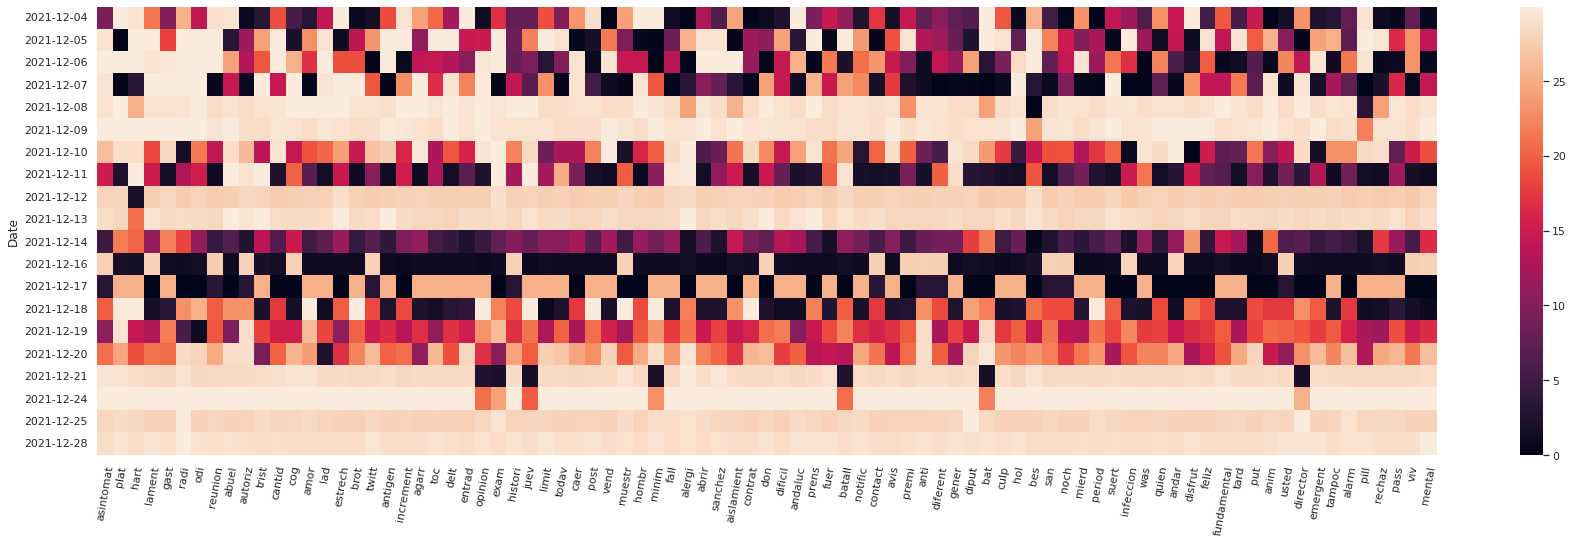

In [ ]:

plot_dataset_heatmap(
    kullback_dataframe_spanish_covid,
    'KLD_spanish_covid',
    limit_features = 85
)

In [ ]:
kullback_dataframe_english_covid = generate_kld_dataframe(
      no_tiny_vocabulary_english_covid_count_based,
      english_covid_df,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


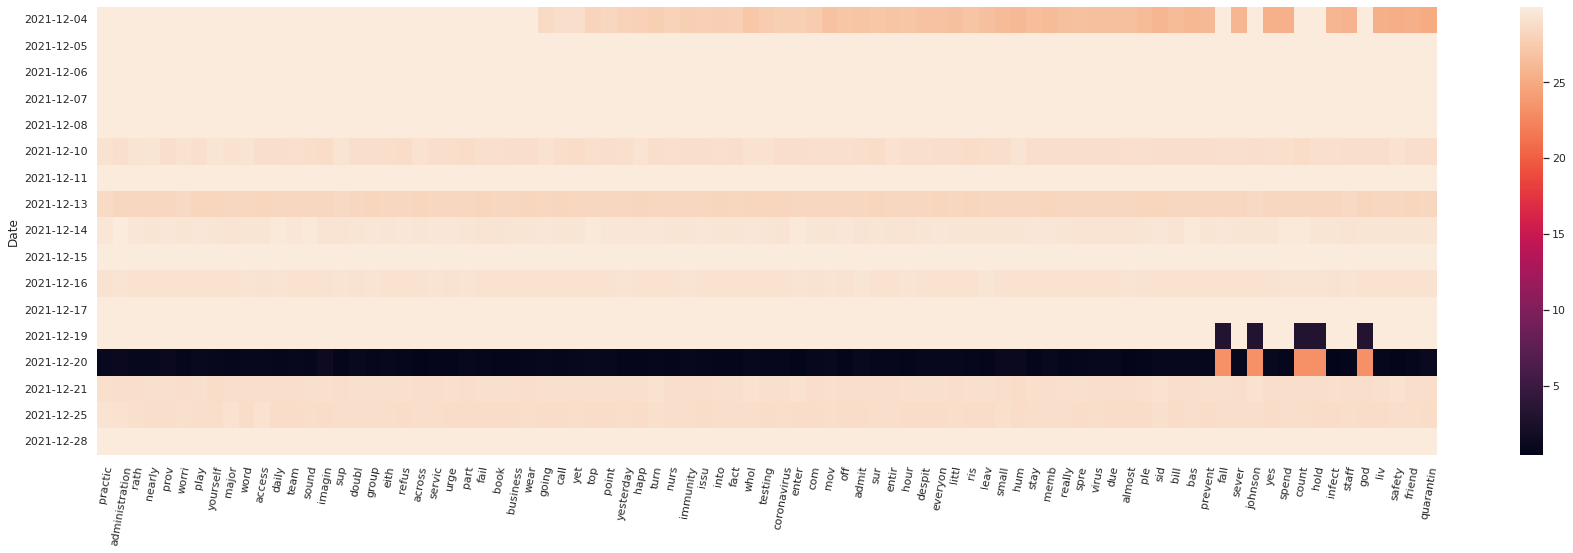

In [ ]:
plot_dataset_heatmap(
    kullback_dataframe_english_covid,
    'KLD_english_covid',
    limit_features = 85
)

In [ ]:
kullback_dataframe_english_palma = generate_kld_dataframe(
      no_tiny_vocabulary_english_palma_count_based,
      english_palma_df,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


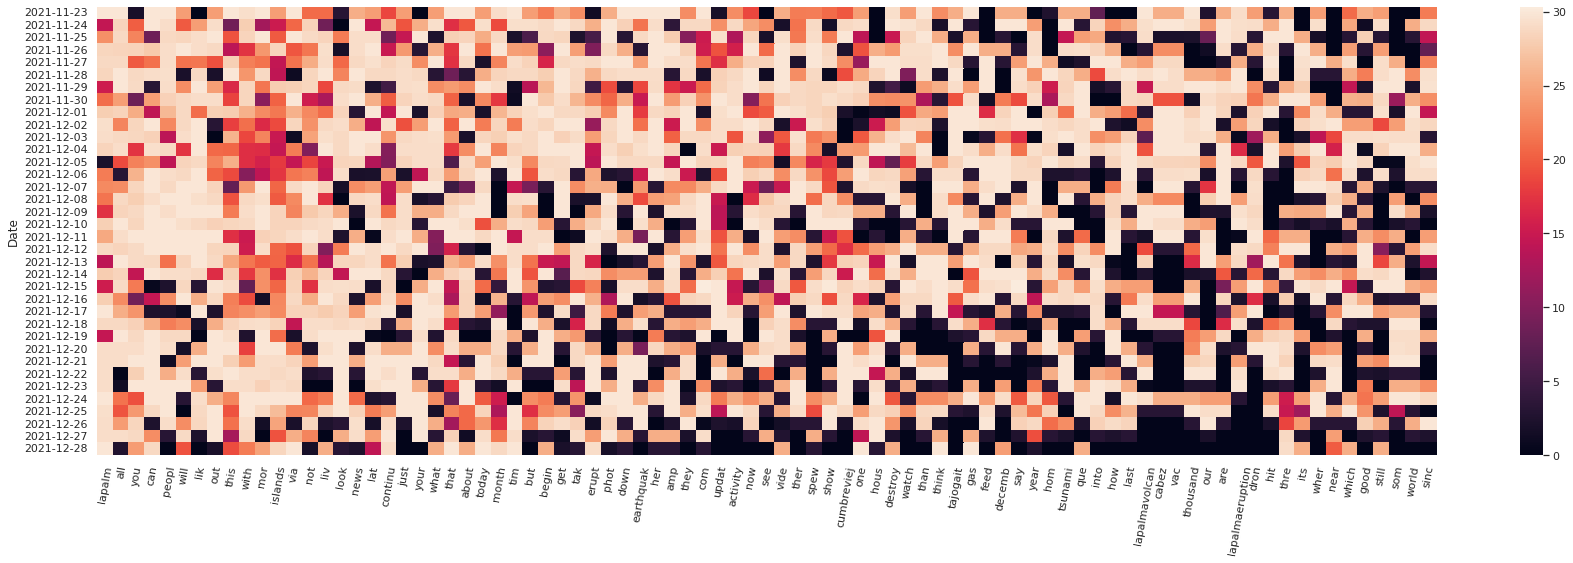

In [ ]:

plot_dataset_heatmap(
    kullback_dataframe_english_palma,
    'KLD_english_palma',
    limit_features = 85
)

In [ ]:
kullback_dataframe_spanish_palma = generate_kld_dataframe(
      no_tiny_vocabulary_spanish_palma_count_based,
      spanish_palma_df,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


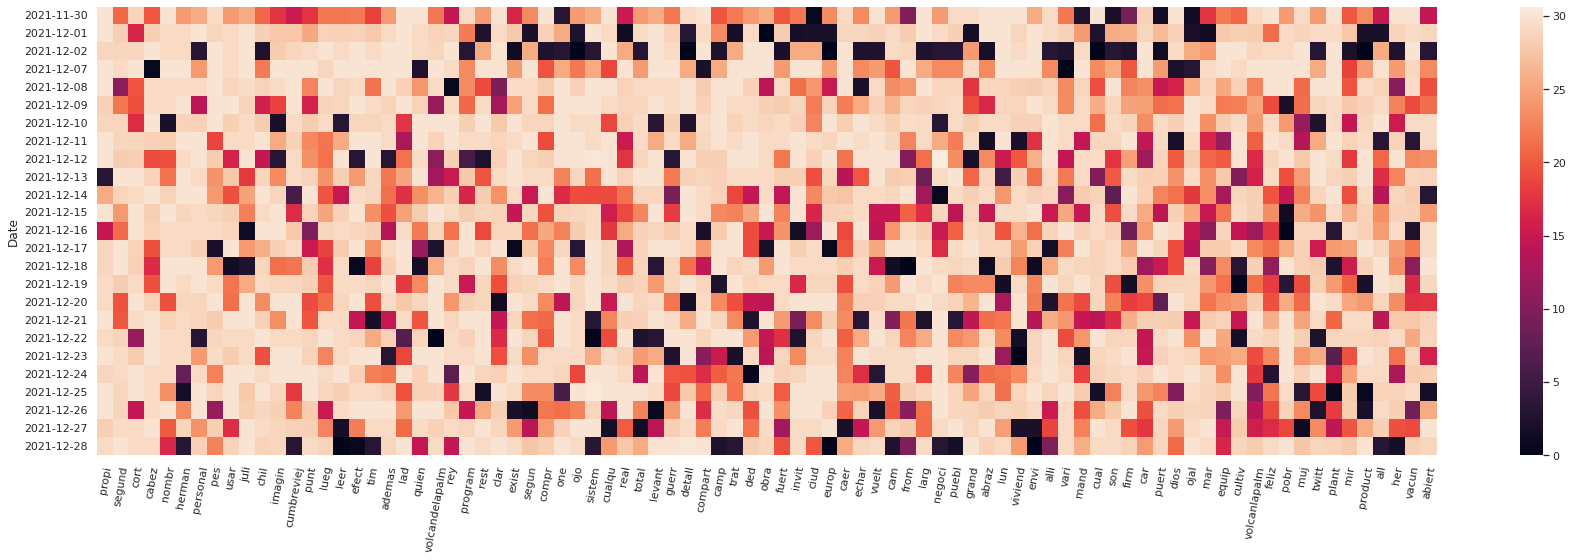

In [ ]:
plot_dataset_heatmap(
    kullback_dataframe_spanish_palma,
    'KLD_spanish_palma',
    limit_features = 85
)

In [ ]:
word = 'immunity'
days_spanish_palma = sorted(get_dates(english_covid_df))
distributions_word_per_day = compute_distribution_per_day(word,
                                                          days_spanish_palma,
                                                          english_covid_df)

In [ ]:
distributions_word_per_day

### 3.1.2 Topic detection with Latent Dirichlet Allocation

A processing will be executed in order to clean up the tweets since some tokens will not provide the sense of topic like emojis. Thus, only words will be considered. <br>
Tokens with whose size is equal to 1 or two will not be considered.

In [ ]:
import re

In [ ]:
def clean_up_tweet_lda(tweet: str, regex) -> str:
  only_words = re.findall(pattern = regex, string = tweet)
  only_words = [ token for token in only_words if len(token) > 2]
  no_links = [ token for token in only_words if 'http' not in token]
  
  cleaned = no_links
  return cleaned

In [ ]:
spanish_covid_df['token_normalization'] = spanish_covid_df['processed_tweet'].apply(lambda tweet: untokenize(clean_up_tweet_lda(tweet, args_loading.regex_tweets['regexOnlyWords'])))
english_covid_df['token_normalization'] = english_covid_df['processed_tweet'].apply(lambda tweet: untokenize(clean_up_tweet_lda(tweet, args_loading.regex_tweets['regexOnlyWords'])))

spanish_palma_df['token_normalization'] = spanish_palma_df['processed_tweet'].apply(lambda tweet: untokenize(clean_up_tweet_lda(tweet, args_loading.regex_tweets['regexOnlyWords'])))
english_palma_df['token_normalization'] = english_palma_df['processed_tweet'].apply(lambda tweet: untokenize(clean_up_tweet_lda(tweet, args_loading.regex_tweets['regexOnlyWords'])))

In [ ]:
args_lda_model = Namespace(
    txt_tweets_storing_path = '/content/data/Data4Model/test',
    hyperparameter_path_file = '/content/data/modelParameters-test.txt',
    path_file_test_with_datasets = '/content/data/filelist_test.txt'

)

In [ ]:
! git clone https://github.com/minghui/Twitter-LDA.git

Cloning into 'Twitter-LDA'...
remote: Enumerating objects: 514, done.
remote: Total 514 (delta 0), reused 0 (delta 0), pack-reused 514
Receiving objects: 100% (514/514), 21.69 MiB | 38.10 MiB/s, done.
Resolving deltas: 100% (34/34), done.


Delete the current data and the current tweets within the GIT repository.

In [ ]:
! rm -rf /content/Twitter-LDA/data/ModelRes
! rm -rf /content/Twitter-LDA/data/Data4Model/test
! rm -rf /content/Twitter-LDA/data/Tokens

Move the data folder into `/content`

In [ ]:
! mv /content/Twitter-LDA/data /content/
! mkdir /content/data/Data4Model/test

Create folders to store the experiments

In [ ]:
! mkdir /content/lda_results
! mkdir /content/lda_results/spanish
! mkdir /content/lda_results/english

In [ ]:
# Compiling the solution 
!javac -d /content/Twitter-LDA/build -cp .:/content/Twitter-LDA/lib/TwitterTokenizer.jar:/content/Twitter-LDA/lib/args4j-2.0.6.jar:/content/Twitter-LDA/lib/jargs.jar /content/Twitter-LDA/src/TwitterLDA/*.java /content/Twitter-LDA/src/Common/*.java 

Note: Some input files use or override a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


First, we define a function to read the `/content/data/filelist_test.txt` file and edit it with the files considered in the experiment.

In [ ]:
def modify_list_entities_file(path_file, file_names):

  with open(path_file, 'w') as file_write:
    file_write.writelines([line + '\n' for line in file_names])

In [ ]:
def write_lda_hyperparameters(path_file, dict_parameters: dict):
  with open(path_file, 'w') as file_write:
    for key, value in dict_parameters.items():
      line = '{parameter}: {value}'.format(parameter = key, value = value)
      file_write.write(line + '\n')     

def get_hyperparameter_configurations(base_configuration: dict,
                                     tweaked_property: str,
                                     values: list) -> list:
  configurations = []
  for value in values:
    copy_base_parameters = base_configuration.copy()
    copy_base_parameters[tweaked_property] = value

    configurations.append(copy_base_parameters)

  return configurations



Now it will be written in different files the `processed_tweet` column for the data frames `spanish_covid_df`, `english_covid_df`, `spanish_palma_df` and `english_palma_df`.

In [ ]:
lda_input_name_files = ['spanish_covid.txt', 'english_covid.txt', 'english_palma.txt', 'spanish_palma.txt']

def write_dataframe_txt(file_path, tweets: list):
  with open(file_path, 'w') as file_write:
    file_write.writelines([tweet + '\n' for tweet in tweets])
    

In [ ]:

# We define the experiments folder. For each parameter setting, it will be created a folder that will contain the experiment results
# The experiments are based in the language and in the parameter setting

def create_experiment_folder(path, dict_parameter: dict):
  """
    A experiment will be codificated as:
    topics{topics}_alphag{alpha_g}_betaw{beta_word}_betab{beta_b}_gamma{gamma}_iters{iteration}
    The later encoding will be the folder which will contain the results
  """
  folder_name = "topics={topics}_alphag={alpha_g}_betaw={beta_word}_betab={beta_b}_gamma={gamma}_iters={iteration}".format(
      topics = dict_parameter['topics'],
      alpha_g = dict_parameter['alpha_g'],
      beta_word = dict_parameter['beta_word'],
      beta_b = dict_parameter['beta_b'],
      gamma = dict_parameter['gamma'],
      iteration = dict_parameter['iteration']
  )
  subprocess.run(['mkdir', path + "/" + folder_name])

  return path + "/" + folder_name

All the experiments will be executed with the baseline parameters below.

In [ ]:
lda_parameters = {'alpha_g': 0.6,
  'beta_b': 0.01,
  'beta_word': 0.01,
  'gamma': 20,
  'iteration': 100,
  'topics': 100
  }

#### Experiments over user-topic $\alpha$ hyperparameter (`alpha_g`)

The experiments will consist in generate topics in function of the data set languages. That is, it will be agglomerated the COVID and La Palma english and spanish data sets and the LDA will be executed.

In [ ]:
experiment = 'alpha_g'
param_values = [0.9, 0.8, 0.6, 0.5, 0.4, 0.35, 0.34, 0.33, 0.32, 0.3, 0.1, 0.09, 0.08, 0.07, 0.05, 0.04, 0.02, 0.01]

In [ ]:
# Steps to reproduce a experiment
# 1º Write the tweets for a given language regardless the entity (covid or palma)

path_tweets_palma = '{base_path_storing_tweets}/english_palma.txt'.format(
                      base_path_storing_tweets = args_lda_model.txt_tweets_storing_path
                      )
write_dataframe_txt(
    file_path= path_tweets_palma,
    tweets= english_palma_df['token_normalization']
)

path_tweets_covid = '{base_path_storing_tweets}/english_covid.txt'.format(
                      base_path_storing_tweets = args_lda_model.txt_tweets_storing_path
                    )
write_dataframe_txt(
    file_path= path_tweets_covid,
    tweets= english_covid_df['token_normalization']
)
# Modify the filelist_test.txt
modify_list_entities_file(
    args_lda_model.path_file_test_with_datasets,
    ['english_palma.txt', 'english_covid.txt']
)

# 2º Write the filelist_test.txt with the names of the .t
# 3º Set the hyperparameters file
hyperparameters = get_hyperparameter_configurations(
    lda_parameters,
    'alpha_g',
    param_values
)
for parameter_config in hyperparameters:

  write_lda_hyperparameters(
      path_file=args_lda_model.hyperparameter_path_file,
      dict_parameters=parameter_config # It will have a iterable of dicts, one for each experiment
  )

  # 3º For the experiment, create a folder
  experiment_folder = '/content/lda_results/english/' + experiment
  subprocess.run(['mkdir', experiment_folder])
  folder_name = create_experiment_folder(experiment_folder, parameter_config)

  # 4º Execute the lda model
  subprocess.run(['java', '-cp', '/content/Twitter-LDA/build', 'TwitterLDA/TwitterLDAmain'])

  # 5º Move the results to the folder in 3º
  subprocess.run(['mv', '/content/data/ModelRes/test', folder_name])
  # 6º Delete the ModelRes folder
  subprocess.run(['rm', '-rf', '/content/data/ModelRes/'])

Lastly, we remove the tweets content

In [ ]:
! rm -rf /content/data/Data4Model/test
! mkdir /content/data/Data4Model/test

For the spanish language, the experiments are executed below

In [ ]:
path_tweets_palma = '{base_path_storing_tweets}/spanish_palma.txt'.format(
                      base_path_storing_tweets = args_lda_model.txt_tweets_storing_path
                      )
write_dataframe_txt(
    file_path= path_tweets_palma,
    tweets= spanish_palma_df['token_normalization']
)

path_tweets_covid = '{base_path_storing_tweets}/spanish_covid.txt'.format(
                      base_path_storing_tweets = args_lda_model.txt_tweets_storing_path
                    )
write_dataframe_txt(
    file_path= path_tweets_covid,
    tweets= spanish_covid_df['token_normalization']
)
# Modify the filelist_test.txt
modify_list_entities_file(
    args_lda_model.path_file_test_with_datasets,
    ['spanish_palma.txt', 'spanish_covid.txt']
)

# 2º Write the filelist_test.txt with the names of the .t
# 3º Set the hyperparameters file
hyperparameters = get_hyperparameter_configurations(
    lda_parameters,
    'alpha_g',
    param_values
)
for parameter_config in hyperparameters:

  write_lda_hyperparameters(
      path_file=args_lda_model.hyperparameter_path_file,
      dict_parameters=parameter_config # It will have a iterable of dicts, one for each experiment
  )

  # 3º For the experiment, create a folder
  experiment_folder = '/content/lda_results/spanish/' + experiment
  subprocess.run(['mkdir', experiment_folder])
  folder_name = create_experiment_folder(experiment_folder, parameter_config)

  # 4º Execute the lda model
  subprocess.run(['java', '-cp', '/content/Twitter-LDA/build', 'TwitterLDA/TwitterLDAmain'])

  # 5º Move the results to the folder in 3º
  subprocess.run(['mv', '/content/data/ModelRes/test', folder_name])
  # 6º Delete the ModelRes folder
  subprocess.run(['rm', '-rf', '/content/data/ModelRes/'])

In [ ]:
! rm -rf /content/data/Data4Model/test
! mkdir /content/data/Data4Model/test

In [ ]:
! rm -rf /content/lda_results/english/alpha_g
! rm -rf /content/lda_results/spanish/alpha_g

#### Experiments over the background word $β$ hyperparameter (`beta_b`).

In [ ]:
experiment = 'beta_b'
param_values = [0.9, 0.8, 0.6, 0.5, 0.4, 0.35, 0.34, 0.33, 0.32, 0.3, 0.1, 0.09, 0.08, 0.07, 0.05, 0.04, 0.02, 0.01]

For the english data

In [ ]:
# Steps to reproduce a experiment
# 1º Write the tweets for a given language regardless the entity (covid or palma)

path_tweets_palma = '{base_path_storing_tweets}/english_palma.txt'.format(
                      base_path_storing_tweets = args_lda_model.txt_tweets_storing_path
                      )
write_dataframe_txt(
    file_path= path_tweets_palma,
    tweets= english_palma_df['token_normalization']
)

path_tweets_covid = '{base_path_storing_tweets}/english_covid.txt'.format(
                      base_path_storing_tweets = args_lda_model.txt_tweets_storing_path
                    )
write_dataframe_txt(
    file_path= path_tweets_covid,
    tweets= english_covid_df['token_normalization']
)
# Modify the filelist_test.txt
modify_list_entities_file(
    args_lda_model.path_file_test_with_datasets,
    ['english_palma.txt', 'english_covid.txt']
)

# 2º Write the filelist_test.txt with the names of the .t
# 3º Set the hyperparameters file
hyperparameters = get_hyperparameter_configurations(
    lda_parameters,
    experiment,
    param_values
)
for parameter_config in hyperparameters:

  write_lda_hyperparameters(
      path_file=args_lda_model.hyperparameter_path_file,
      dict_parameters=parameter_config # It will have a iterable of dicts, one for each experiment
  )

  # 3º For the experiment, create a folder
  experiment_folder = '/content/lda_results/english/' + experiment
  subprocess.run(['mkdir', experiment_folder])
  folder_name = create_experiment_folder(experiment_folder, parameter_config)

  # 4º Execute the lda model
  subprocess.run(['java', '-cp', '/content/Twitter-LDA/build', 'TwitterLDA/TwitterLDAmain'])

  # 5º Move the results to the folder in 3º
  subprocess.run(['mv', '/content/data/ModelRes/test', folder_name])
  # 6º Delete the ModelRes folder
  subprocess.run(['rm', '-rf', '/content/data/ModelRes/'])

! rm -rf /content/data/Data4Model/test
! mkdir /content/data/Data4Model/test

For the spanish data

In [ ]:
path_tweets_palma = '{base_path_storing_tweets}/spanish_palma.txt'.format(
                      base_path_storing_tweets = args_lda_model.txt_tweets_storing_path
                      )
write_dataframe_txt(
    file_path= path_tweets_palma,
    tweets= spanish_palma_df['token_normalization']
)

path_tweets_covid = '{base_path_storing_tweets}/spanish_covid.txt'.format(
                      base_path_storing_tweets = args_lda_model.txt_tweets_storing_path
                    )
write_dataframe_txt(
    file_path= path_tweets_covid,
    tweets= spanish_covid_df['token_normalization']
)
# Modify the filelist_test.txt
modify_list_entities_file(
    args_lda_model.path_file_test_with_datasets,
    ['spanish_palma.txt', 'spanish_covid.txt']
)

# 2º Write the filelist_test.txt with the names of the .t
# 3º Set the hyperparameters file
hyperparameters = get_hyperparameter_configurations(
    lda_parameters,
    experiment,
    param_values
)
for parameter_config in hyperparameters:

  write_lda_hyperparameters(
      path_file=args_lda_model.hyperparameter_path_file,
      dict_parameters=parameter_config # It will have a iterable of dicts, one for each experiment
  )

  # 3º For the experiment, create a folder
  experiment_folder = '/content/lda_results/spanish/' + experiment
  subprocess.run(['mkdir', experiment_folder])
  folder_name = create_experiment_folder(experiment_folder, parameter_config)

  # 4º Execute the lda model
  subprocess.run(['java', '-cp', '/content/Twitter-LDA/build', 'TwitterLDA/TwitterLDAmain'])

  # 5º Move the results to the folder in 3º
  subprocess.run(['mv', '/content/data/ModelRes/test', folder_name])
  # 6º Delete the ModelRes folder
  subprocess.run(['rm', '-rf', '/content/data/ModelRes/'])

! rm -rf /content/data/Data4Model/test
! mkdir /content/data/Data4Model/test

In [ ]:
! rm -rf /content/lda_results/en/beta_b

#### Experiments over the $β$ functional word hyperparameter (`beta_word`)

In [ ]:
experiment = 'beta_word'
param_values = [0.9, 0.8, 0.6, 0.5, 0.4, 0.35, 0.34, 0.33, 0.32, 0.3, 0.1, 0.09, 0.08, 0.07, 0.05, 0.04, 0.02, 0.01]

For the english data

In [ ]:
path_tweets_palma = '{base_path_storing_tweets}/english_palma.txt'.format(
                      base_path_storing_tweets = args_lda_model.txt_tweets_storing_path
                      )
write_dataframe_txt(
    file_path= path_tweets_palma,
    tweets= english_palma_df['token_normalization']
)

path_tweets_covid = '{base_path_storing_tweets}/english_covid.txt'.format(
                      base_path_storing_tweets = args_lda_model.txt_tweets_storing_path
                    )
write_dataframe_txt(
    file_path= path_tweets_covid,
    tweets= english_covid_df['token_normalization']
)
# Modify the filelist_test.txt
modify_list_entities_file(
    args_lda_model.path_file_test_with_datasets,
    ['english_palma.txt', 'english_covid.txt']
)

# 2º Write the filelist_test.txt with the names of the .t
# 3º Set the hyperparameters file
hyperparameters = get_hyperparameter_configurations(
    lda_parameters,
    experiment,
    param_values
)
for parameter_config in hyperparameters:

  write_lda_hyperparameters(
      path_file=args_lda_model.hyperparameter_path_file,
      dict_parameters=parameter_config # It will have a iterable of dicts, one for each experiment
  )

  # 3º For the experiment, create a folder
  experiment_folder = '/content/lda_results/english/' + experiment
  subprocess.run(['mkdir', experiment_folder])
  folder_name = create_experiment_folder(experiment_folder, parameter_config)

  # 4º Execute the lda model
  subprocess.run(['java', '-cp', '/content/Twitter-LDA/build', 'TwitterLDA/TwitterLDAmain'])

  # 5º Move the results to the folder in 3º
  subprocess.run(['mv', '/content/data/ModelRes/test', folder_name])
  # 6º Delete the ModelRes folder
  subprocess.run(['rm', '-rf', '/content/data/ModelRes/'])

! rm -rf /content/data/Data4Model/test
! mkdir /content/data/Data4Model/test

For the spanish data

In [ ]:
path_tweets_palma = '{base_path_storing_tweets}/spanish_palma.txt'.format(
                      base_path_storing_tweets = args_lda_model.txt_tweets_storing_path
                      )
write_dataframe_txt(
    file_path= path_tweets_palma,
    tweets= spanish_palma_df['token_normalization']
)

path_tweets_covid = '{base_path_storing_tweets}/spanish_covid.txt'.format(
                      base_path_storing_tweets = args_lda_model.txt_tweets_storing_path
                    )
write_dataframe_txt(
    file_path= path_tweets_covid,
    tweets= spanish_covid_df['token_normalization']
)
# Modify the filelist_test.txt
modify_list_entities_file(
    args_lda_model.path_file_test_with_datasets,
    ['spanish_palma.txt', 'spanish_covid.txt']
)

# 2º Write the filelist_test.txt with the names of the .t
# 3º Set the hyperparameters file
hyperparameters = get_hyperparameter_configurations(
    lda_parameters,
    experiment,
    param_values
)
for parameter_config in hyperparameters:

  write_lda_hyperparameters(
      path_file=args_lda_model.hyperparameter_path_file,
      dict_parameters=parameter_config # It will have a iterable of dicts, one for each experiment
  )

  # 3º For the experiment, create a folder
  experiment_folder = '/content/lda_results/spanish/' + experiment
  subprocess.run(['mkdir', experiment_folder])
  folder_name = create_experiment_folder(experiment_folder, parameter_config)

  # 4º Execute the lda model
  subprocess.run(['java', '-cp', '/content/Twitter-LDA/build', 'TwitterLDA/TwitterLDAmain'])

  # 5º Move the results to the folder in 3º
  subprocess.run(['mv', '/content/data/ModelRes/test', folder_name])
  # 6º Delete the ModelRes folder
  subprocess.run(['rm', '-rf', '/content/data/ModelRes/'])

! rm -rf /content/data/Data4Model/test
! mkdir /content/data/Data4Model/test

In [ ]:
!zip -r '/content/lda_results_beta_word.zip' '/content/lda_results'

In [ ]:
! rm -rf /content/lda_results/english/beta_word
! rm -rf /content/lda_results/spanish/beta_word

#### Experiments over the $γ$ parameter (gamma)

In [ ]:
experiment = 'gamma'
param_values = [50, 20, 15, 13, 10, 9, 9.5, 9.1, 8.1, 5, 2, 1, 0.8, 0.5, 0.2, 0.1, 0.09, 0.02]

For the english data

In [ ]:
path_tweets_palma = '{base_path_storing_tweets}/english_palma.txt'.format(
                      base_path_storing_tweets = args_lda_model.txt_tweets_storing_path
                      )
write_dataframe_txt(
    file_path= path_tweets_palma,
    tweets= english_palma_df['token_normalization']
)

path_tweets_covid = '{base_path_storing_tweets}/english_covid.txt'.format(
                      base_path_storing_tweets = args_lda_model.txt_tweets_storing_path
                    )
write_dataframe_txt(
    file_path= path_tweets_covid,
    tweets= english_covid_df['token_normalization']
)
# Modify the filelist_test.txt
modify_list_entities_file(
    args_lda_model.path_file_test_with_datasets,
    ['english_palma.txt', 'english_covid.txt']
)

# 2º Write the filelist_test.txt with the names of the .t
# 3º Set the hyperparameters file
hyperparameters = get_hyperparameter_configurations(
    lda_parameters,
    experiment,
    param_values
)
for parameter_config in hyperparameters:

  write_lda_hyperparameters(
      path_file=args_lda_model.hyperparameter_path_file,
      dict_parameters=parameter_config # It will have a iterable of dicts, one for each experiment
  )

  # 3º For the experiment, create a folder
  experiment_folder = '/content/lda_results/english/' + experiment
  subprocess.run(['mkdir', experiment_folder])
  folder_name = create_experiment_folder(experiment_folder, parameter_config)

  # 4º Execute the lda model
  subprocess.run(['java', '-cp', '/content/Twitter-LDA/build', 'TwitterLDA/TwitterLDAmain'])

  # 5º Move the results to the folder in 3º
  subprocess.run(['mv', '/content/data/ModelRes/test', folder_name])
  # 6º Delete the ModelRes folder
  subprocess.run(['rm', '-rf', '/content/data/ModelRes/'])

! rm -rf /content/data/Data4Model/test
! mkdir /content/data/Data4Model/test

For the spanish data

In [ ]:
path_tweets_palma = '{base_path_storing_tweets}/spanish_palma.txt'.format(
                      base_path_storing_tweets = args_lda_model.txt_tweets_storing_path
                      )
write_dataframe_txt(
    file_path= path_tweets_palma,
    tweets= spanish_palma_df['token_normalization']
)

path_tweets_covid = '{base_path_storing_tweets}/spanish_covid.txt'.format(
                      base_path_storing_tweets = args_lda_model.txt_tweets_storing_path
                    )
write_dataframe_txt(
    file_path= path_tweets_covid,
    tweets= spanish_covid_df['token_normalization']
)
# Modify the filelist_test.txt
modify_list_entities_file(
    args_lda_model.path_file_test_with_datasets,
    ['spanish_palma.txt', 'spanish_covid.txt']
)

# 2º Write the filelist_test.txt with the names of the .t
# 3º Set the hyperparameters file
hyperparameters = get_hyperparameter_configurations(
    lda_parameters,
    experiment,
    param_values
)
for parameter_config in hyperparameters:

  write_lda_hyperparameters(
      path_file=args_lda_model.hyperparameter_path_file,
      dict_parameters=parameter_config # It will have a iterable of dicts, one for each experiment
  )

  # 3º For the experiment, create a folder
  experiment_folder = '/content/lda_results/spanish/' + experiment
  subprocess.run(['mkdir', experiment_folder])
  folder_name = create_experiment_folder(experiment_folder, parameter_config)

  # 4º Execute the lda model
  subprocess.run(['java', '-cp', '/content/Twitter-LDA/build', 'TwitterLDA/TwitterLDAmain'])

  # 5º Move the results to the folder in 3º
  subprocess.run(['mv', '/content/data/ModelRes/test', folder_name])
  # 6º Delete the ModelRes folder
  subprocess.run(['rm', '-rf', '/content/data/ModelRes/'])

! rm -rf /content/data/Data4Model/test
! mkdir /content/data/Data4Model/test

In [ ]:
!zip -r '/content/lda_results_gamma.zip' '/content/lda_results'

  adding: content/lda_results/ (stored 0%)
  adding: content/lda_results/english/ (stored 0%)
  adding: content/lda_results/english/gamma/ (stored 0%)
  adding: content/lda_results/english/gamma/topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=5_iters=100/ (stored 0%)
  adding: content/lda_results/english/gamma/topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=5_iters=100/test/ (stored 0%)
  adding: content/lda_results/english/gamma/topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=5_iters=100/test/BackgroundWordsDistribution.txt (deflated 50%)
  adding: content/lda_results/english/gamma/topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=5_iters=100/test/wordMap.txt (deflated 44%)
  adding: content/lda_results/english/gamma/topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=5_iters=100/test/TopicsDistributionOnUsers.txt (deflated 69%)
  adding: content/lda_results/english/gamma/topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=5_iters=100/test/uniWordMap.txt (deflated 44%)
  adding: con

#### LDA visualization: Words in topics and topic distribution per data set

In [ ]:
lda_english_path_result = '/content/drive/MyDrive/lda_results_20iter/english/beta_b/topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=20_iters=20'
lda_spanish_path_result = '/content/drive/MyDrive/lda_results_20iter/spanish/beta_b/topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=20_iters=20'

In [ ]:
! gdown https://drive.google.com/uc?id=1A3muu9dvMRkBw4CXMJY4ys54aCP_HM29
! gdown https://drive.google.com/uc?id=1HIdcfH7Rl6go4-Vli6QRImQ6IFUZ03Qm

Downloading...
From: https://drive.google.com/uc?id=1A3muu9dvMRkBw4CXMJY4ys54aCP_HM29
To: /content/english_topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=20_iters=20.zip
100% 4.99M/4.99M [00:00<00:00, 43.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HIdcfH7Rl6go4-Vli6QRImQ6IFUZ03Qm
To: /content/spanish_topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=20_iters=20.zip
100% 5.77M/5.77M [00:00<00:00, 38.5MB/s]


In [ ]:
! unzip /content/english_topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=20_iters=20.zip -d /content/lda_english
! unzip /content/spanish_topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=20_iters=20.zip -d /content/lda_spanish

Archive:  /content/english_topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=20_iters=20.zip
  inflating: /content/lda_english/topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=20_iters=20/test/TopicsDistributionOnUsers.txt  
  inflating: /content/lda_english/topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=20_iters=20/test/BackgroundWordsDistribution.txt  
  inflating: /content/lda_english/topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=20_iters=20/test/TopicCountsOnUsers.txt  
  inflating: /content/lda_english/topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=20_iters=20/test/WordsInTopics.txt  
  inflating: /content/lda_english/topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=20_iters=20/test/uniWordMap.txt  
  inflating: /content/lda_english/topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=20_iters=20/test/wordMap.txt  
  inflating: /content/lda_english/topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=20_iters=20/test/TextWithLabel/english_palma.txt  
  inflating: /content/ld

In [ ]:
lda_english_path_result = '/content/lda_english/topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=20_iters=20/test'
lda_spanish_path_result = '/content/lda_spanish/topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=20_iters=20/test'

In [ ]:
! ls /content/lda_english/topics=100_alphag=0.6_betaw=0.01_betab=0.01_gamma=20_iters=20/test

BackgroundWordsDistribution.txt  uniWordMap.txt
TextWithLabel			 wordMap.txt
TopicCountsOnUsers.txt		 WordsInTopics.txt
TopicsDistributionOnUsers.txt


#### Reading WordsInTopics files

We read the file

In [ ]:
def read_words_in_topics(path):

  lines_lda_words_in_topics = []
  with open(path, 'r') as file_read:
    # a = file_read.readlines()
    for line in file_read:
      lines_lda_words_in_topics.append(line.strip().split("\t"))
      processed_line = line.strip().split("\t")

  return lines_lda_words_in_topics



Next, we process the read file to look for the boundaries for a topic

In [ ]:
def is_topic_line(line):
  return 'Topic' in line[0]

def get_topic_indexes(read_topics):
  index_topic = []
  for index, line in enumerate(read_topics):
    
    if is_topic_line(line):
      index_topic.append(index)
      
  index_topic.append(len(read_topics))

  return index_topic

We get the topics given a list of tuples `(index_start, index_end)` that denotes the start and end of a topic.

In [ ]:
def get_topics(tuple_start_end_topic, read_topics):
  topics = []
  for start, end in tuple_start_end_topic:
    topics.append(read_topics[start:end])

  return topics

**For the English data**

In [ ]:
read_topics_english = read_words_in_topics(lda_english_path_result + '/WordsInTopics.txt')

indexes_english_topics = get_topic_indexes(read_topics_english)
tuple_start_ends_line_topics_english = list(zip(indexes_english_topics[: -1], indexes_english_topics[1:]))

topics_english_lda = get_topics(tuple_start_ends_line_topics_english, read_topics_english)

In [ ]:
topics_english_lda[0]

[['Topic 0:', 'lik', '0.04344098'],
 ['drop', '0.03983215'],
 ['cov', '0.03969849'],
 ['lot', '0.019382099'],
 ['sound', '0.019248439'],
 ['befor', '0.016976213'],
 ['album', '0.014169343'],
 ['ends', '0.0139020225'],
 ['dead', '0.0139020225'],
 ['list', '0.013634701'],
 ['rihann', '0.012298097'],
 ['startin', '0.011763455'],
 ['young', '0.011095153'],
 ['recently', '0.011095153'],
 ['gta', '0.010961493'],
 ['athlet', '0.010827832'],
 ['peopl', '0.009892209'],
 ['thos', '0.009491228'],
 ['suddenly', '0.009357567'],
 ['cvglzppfsh', '0.008689265'],
 ['vaccinat', '0.008689265'],
 ['hospital', '0.008555605'],
 ['amp', '0.0084219435'],
 ['mask', '0.008288284'],
 ['thought', '0.008288284'],
 ['everyon', '0.008020963'],
 ['yesterday', '0.006684358'],
 ['family', '0.006684358'],
 ['thes', '0.006684358'],
 ['test', '0.0065506976']]

**For the Spanish data**

In [ ]:
read_topics_spanish = read_words_in_topics(lda_spanish_path_result + '/WordsInTopics.txt')

indexes_spanish_topics = get_topic_indexes(read_topics_spanish)
tuple_start_ends_line_topics_spanish = list(zip(indexes_spanish_topics[: -1], indexes_spanish_topics[1:]))

topics_spanish_lda = get_topics(tuple_start_ends_line_topics_spanish, read_topics_spanish)

In [ ]:
topics_spanish_lda[0]

[['Topic 0:', 'hav', '0.010986756'],
 ['lik', '0.008712384'],
 ['mor', '0.006630756'],
 ['peopl', '0.00651511'],
 ['don', '0.0062067206'],
 ['hab', '0.0059754285'],
 ['christm', '0.005435747'],
 ['tim', '0.0053971987'],
 ['amp', '0.00535865'],
 ['lov', '0.0049346145'],
 ['good', '0.004857518'],
 ['day', '0.0043563847'],
 ['today', '0.0038167036'],
 ['som', '0.0035468629'],
 ['year', '0.0033541196'],
 ['ther', '0.003084279'],
 ['mak', '0.0029686328'],
 ['happy', '0.0029686328'],
 ['becaus', '0.0029300842'],
 ['work', '0.0025445975'],
 ['wer', '0.0022747568'],
 ['merry', '0.0021976593'],
 ['thes', '0.0021976593'],
 ['tak', '0.0021591107'],
 ['giv', '0.0020820135'],
 ['back', '0.002004916'],
 ['vide', '0.0019278188'],
 ['lif', '0.0018507214'],
 ['nev', '0.0018507214'],
 ['someon', '0.0018121727']]

Next we define a function to process a topic. 

In [ ]:
def process_topic(topic):
  
  words = []
  values = []
  for item in topic:

    word = item[0]
    value = item[1]
    if is_topic_line(item):
      word = item[1]
      value = item[2]

    words.append(word)
    values.append(float(value))

  df = pd.DataFrame(data = {'words': words, 'values': values})
  return df

Now, we define a function to plot the topics

In [ ]:
# sns.set(rc={'figure.figsize':(7.25,8.25)})
def plot_topics(topic_dataframes, pic_name, x_size_grid = 5, y_size_grid = 5):
  fig, axes = plt.subplots(x_size_grid, y_size_grid, figsize=(30,32))
  axes = axes.ravel()  # flattening the array makes indexing easier
  cols = ['Topic {n}'.format(n=i) for i in range(x_size_grid * y_size_grid)]

  i = 0
  for col, ax in zip(cols, axes):
      sns.barplot(x="values", y="words", data=topic_dataframes[i], ax=ax).set(title='Topic #{n}'.format(n = i + 1))
      i += 1
      
  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.3)
  fig.savefig('{name}.png'.format(name = pic_name), dpi=150)
  plt.show()

In [ ]:
plot_topics(d, "test")

Next, we plot all the topics for the given LDA results

In [ ]:
def plot_lda_words_in_topic(topics, pic_name):

  topic_dataframes = [ process_topic(topic) for topic in topics]
  plot_topics(topic_dataframes, pic_name)

**The plot of the topics for the English language**

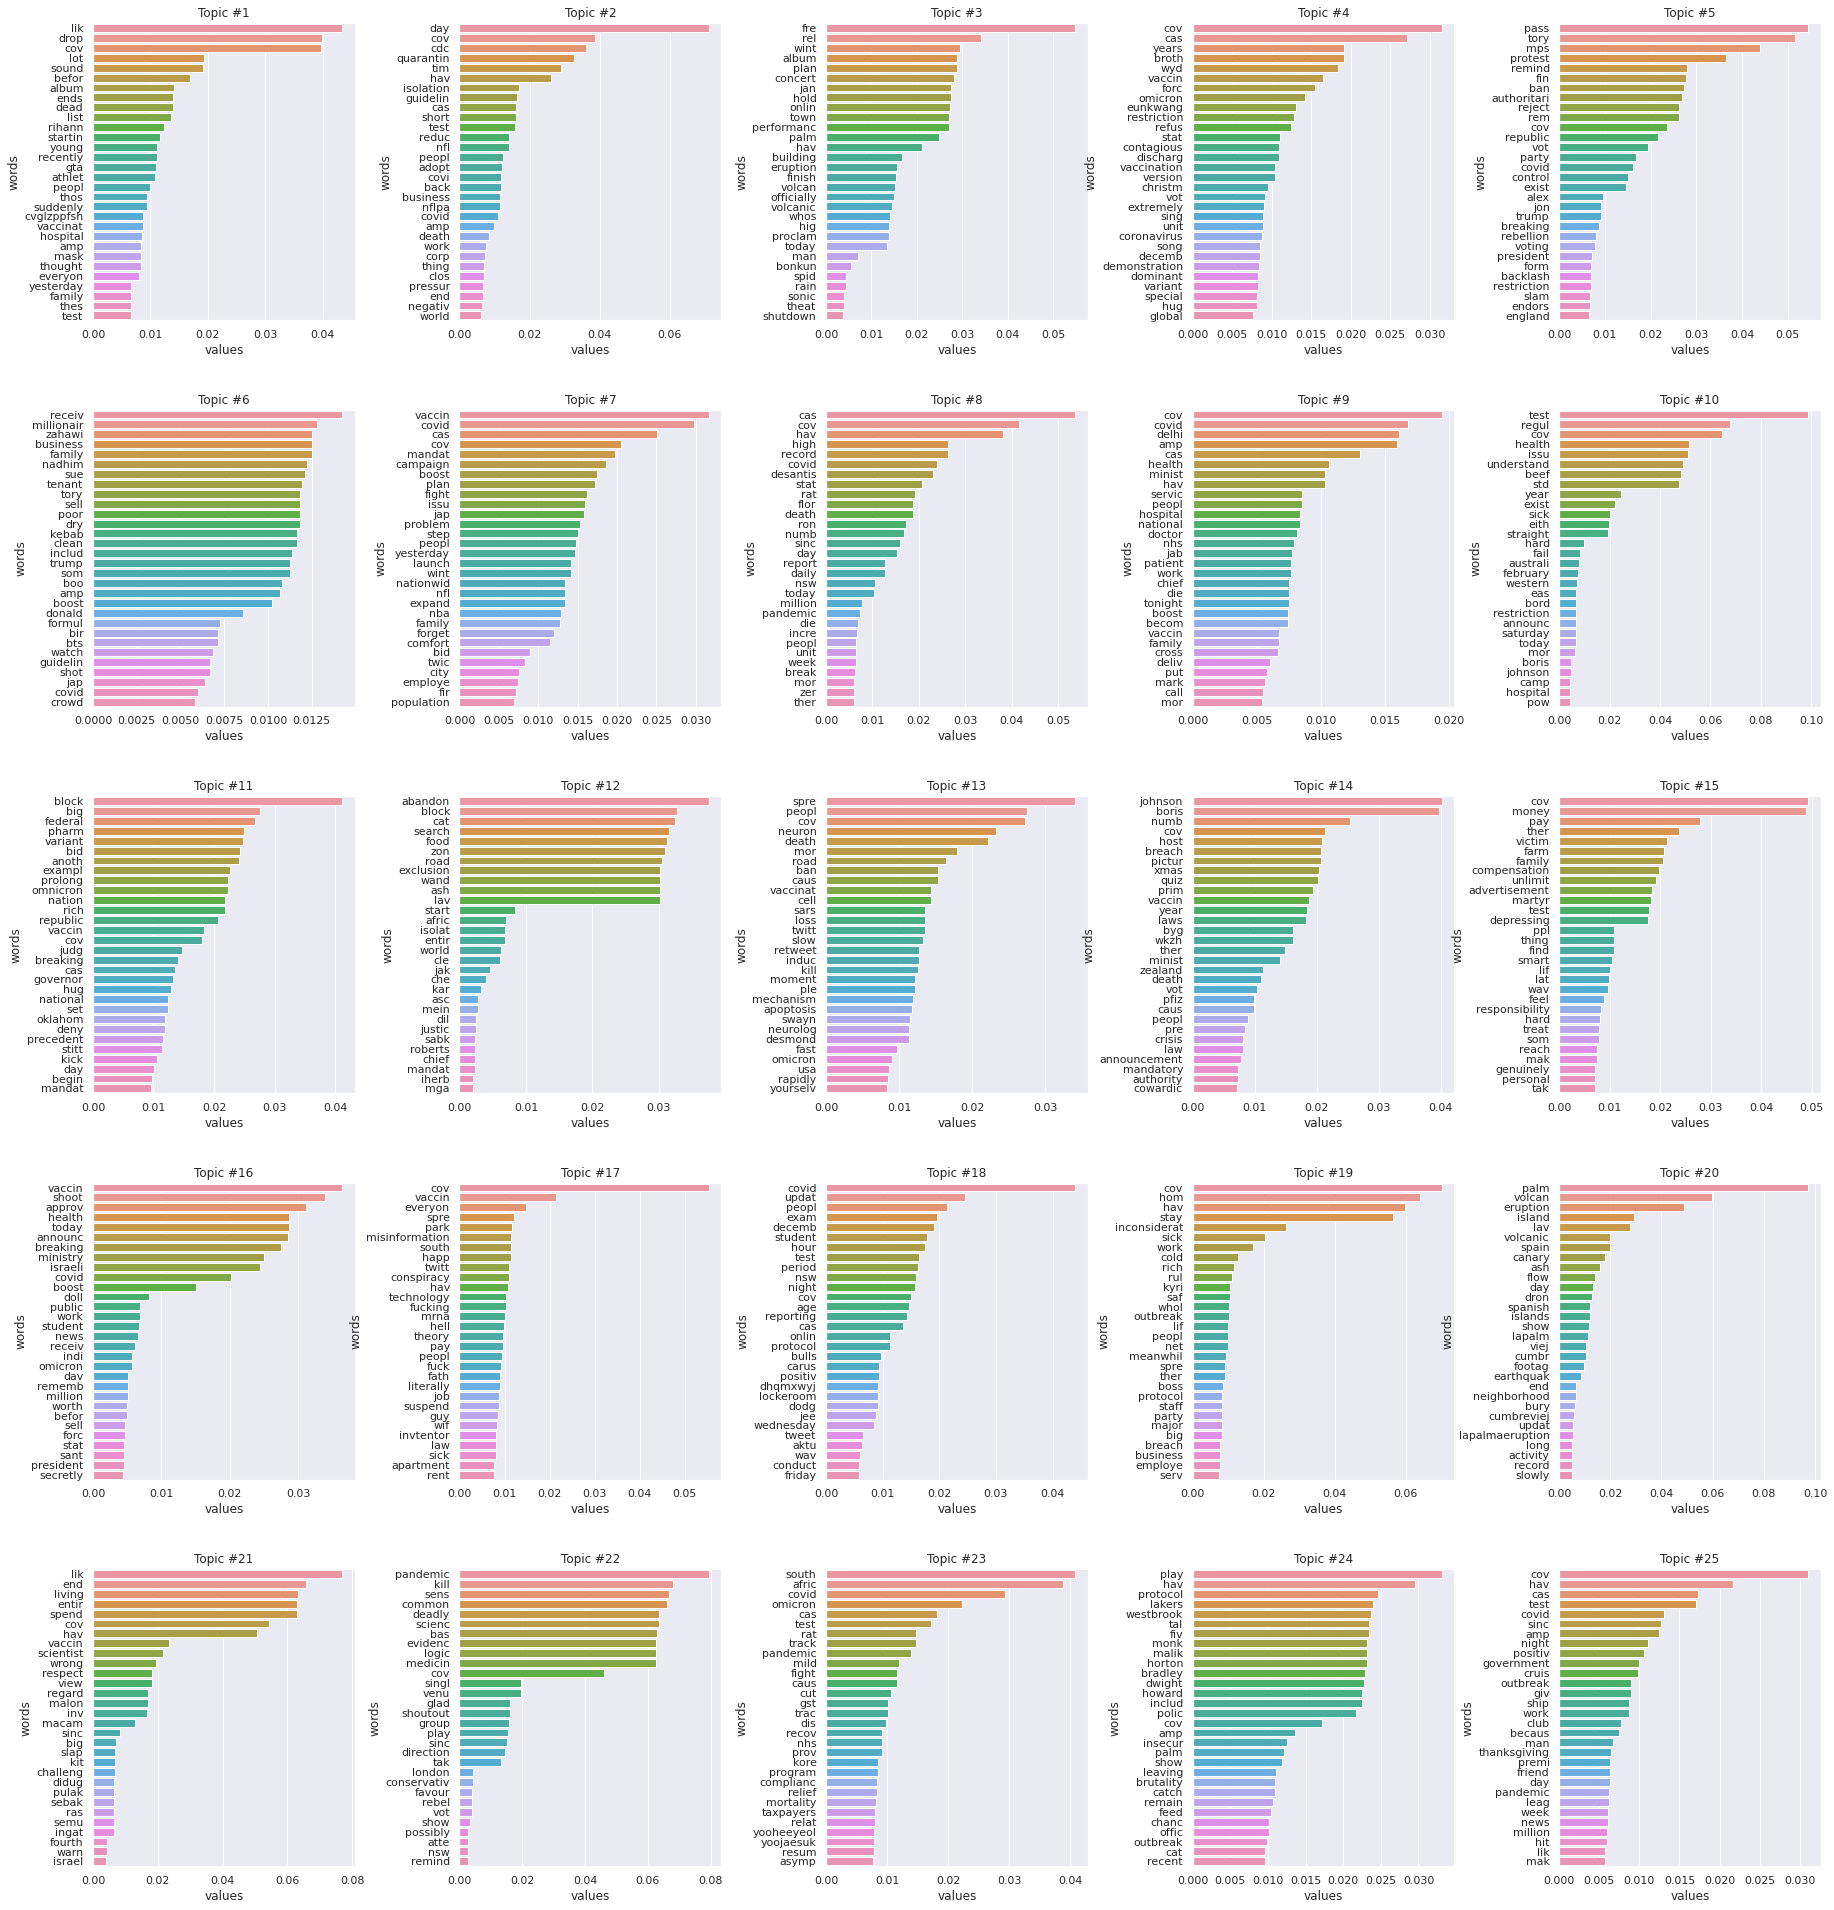

In [ ]:
plot_lda_words_in_topic(topics_english_lda[:25], 'lda_english')

The plot of the topics for the Spanish language

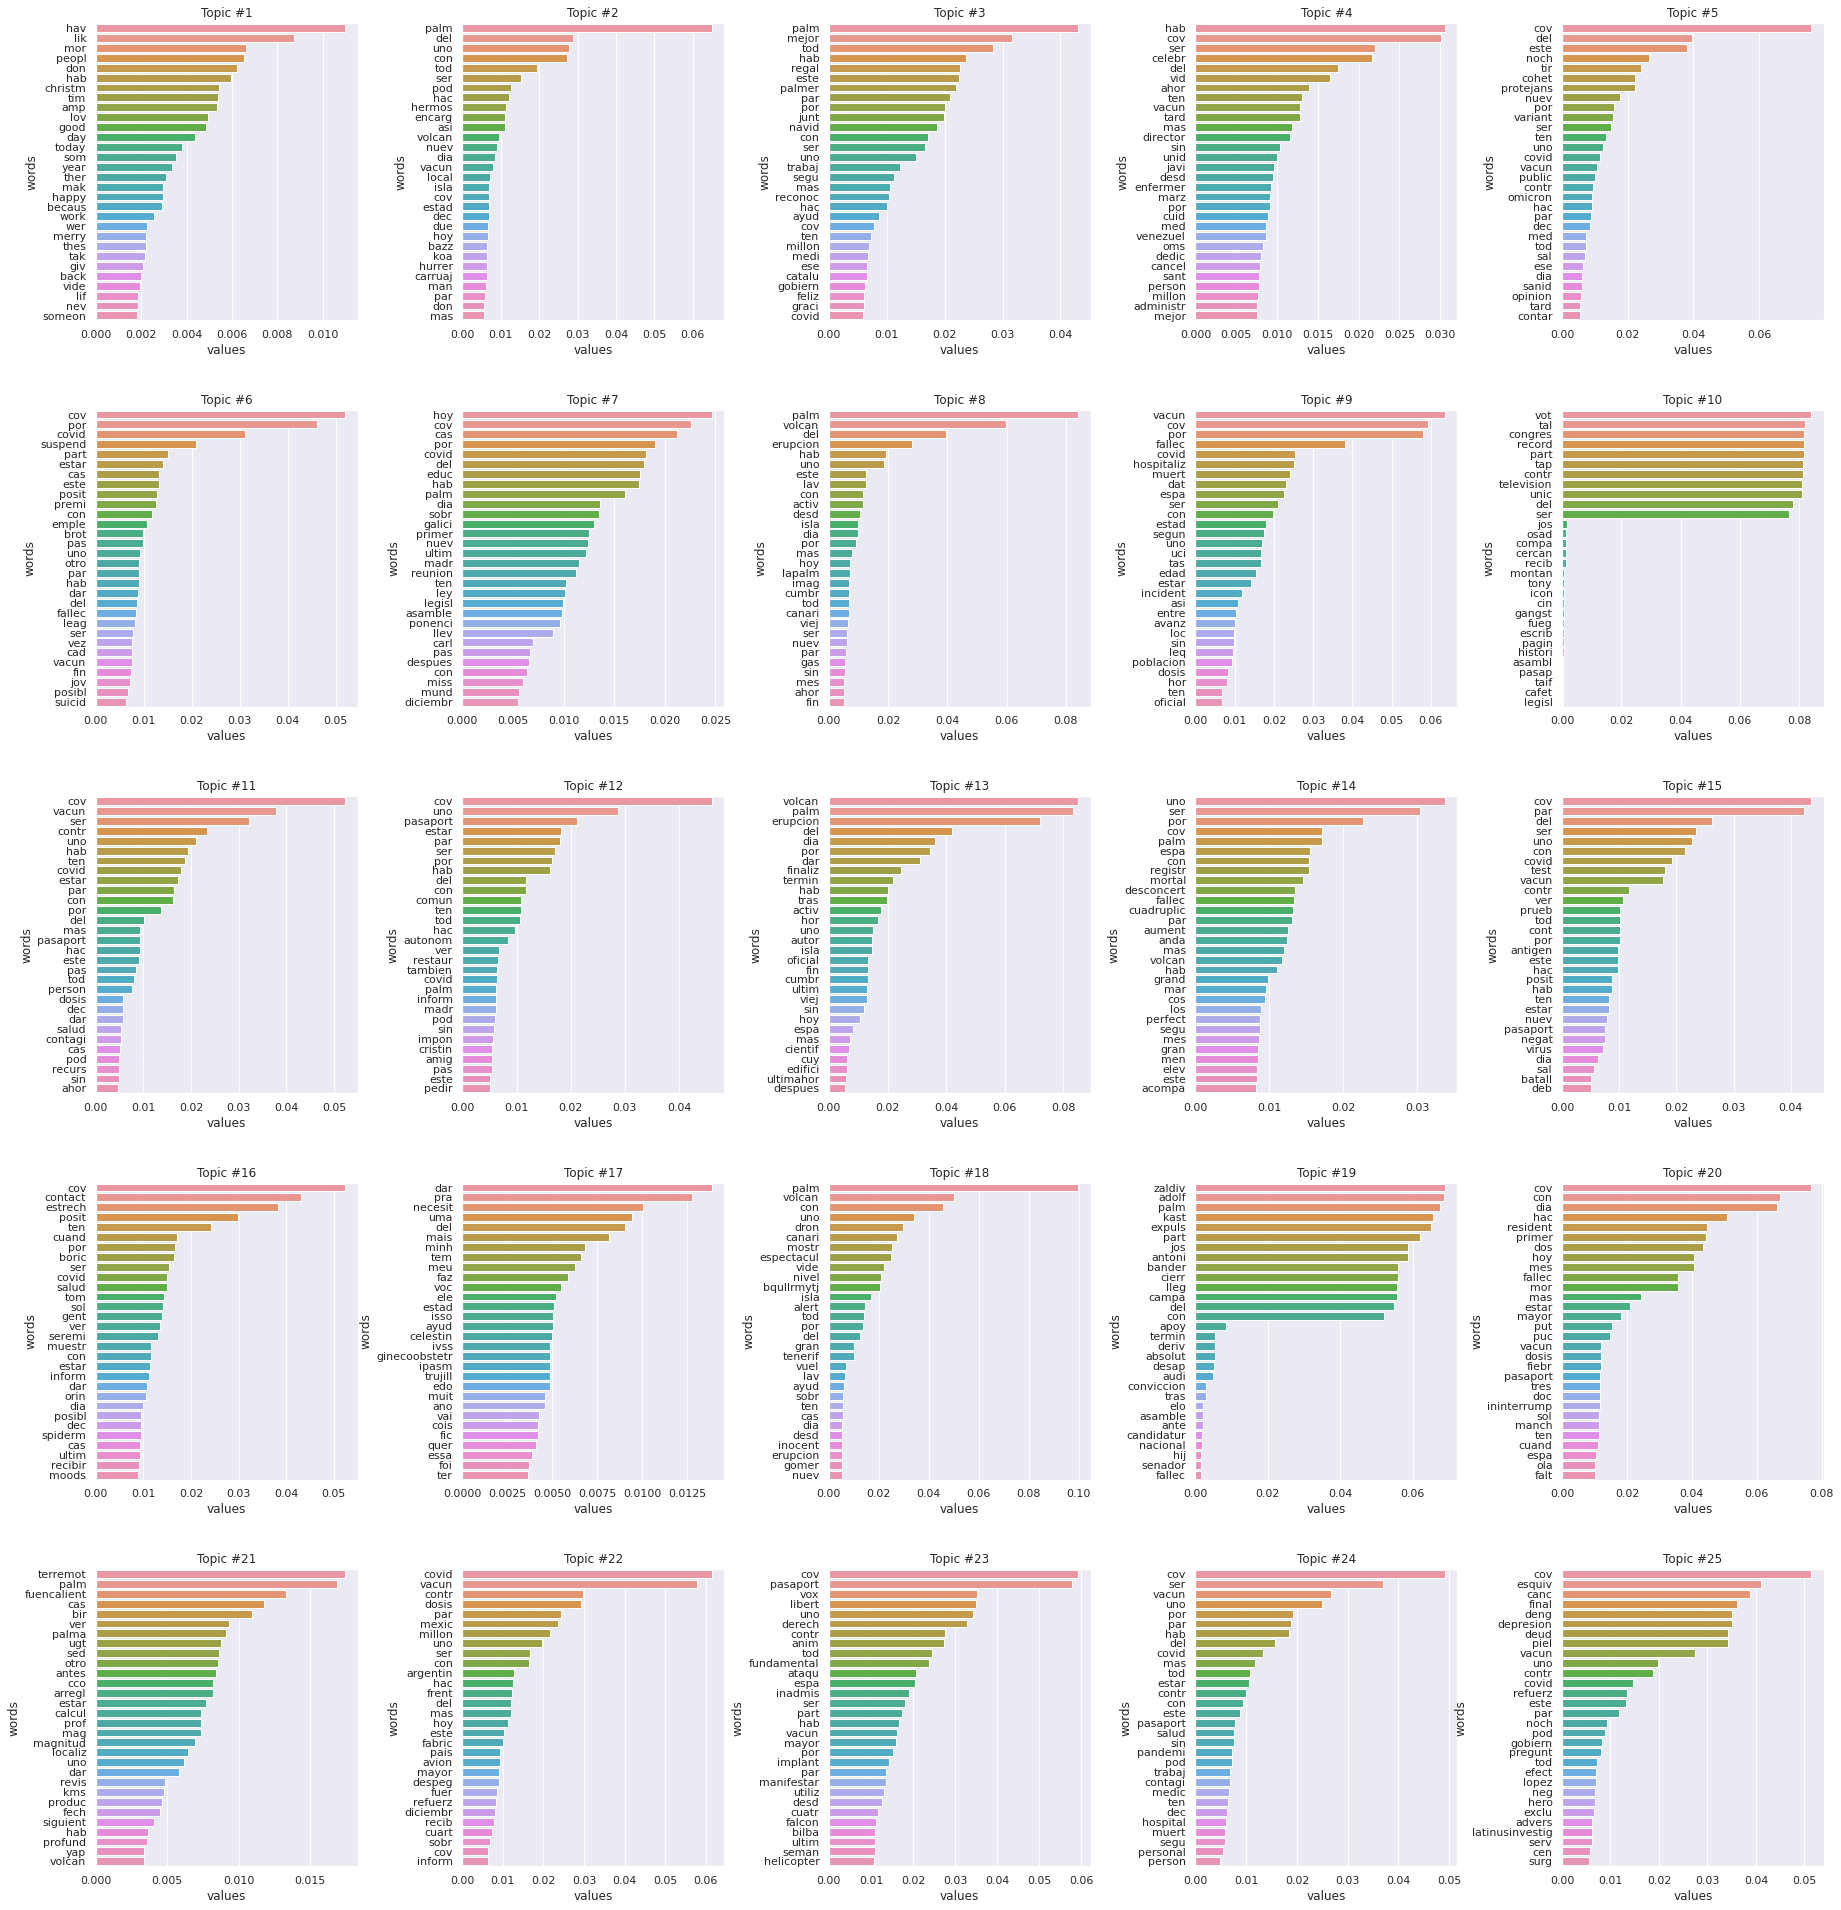

In [ ]:
plot_lda_words_in_topic(topics_spanish_lda[:25], 'lda_spanish')

Now we read the topic distribution per data set and language.

**Topic distribution for Spanish tweets**

In [ ]:
spanish_topic_distribution = read_words_in_topics(lda_spanish_path_result + '/TopicsDistributionOnUsers.txt')

In [ ]:
dist_spanish_palma = spanish_topic_distribution[0]
values_dist_spanish_palma = [float(value) for value in dist_spanish_palma[1:]]

topics = ['Topic #{n}'.format(n = i+1) for i in range(len(values_dist_spanish_palma))]
df_topic_distribution_spanish_palma = pd.DataFrame(data = {'Topics': topics, 'Values': values_dist_spanish_palma})

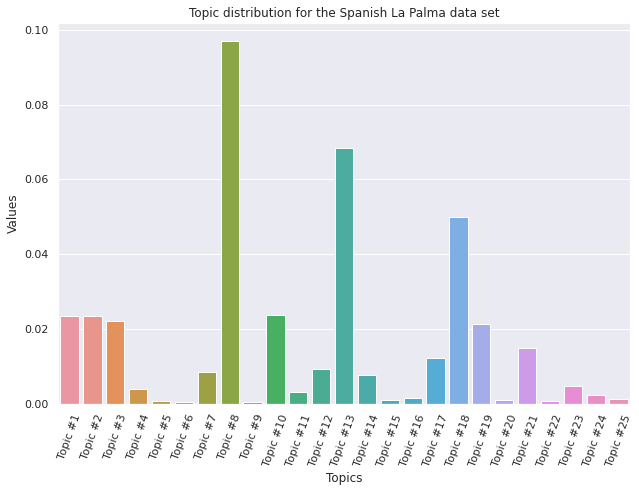

In [ ]:

sns.set(rc={'figure.figsize':(10.25, 7)})
sns_plot = sns.barplot(x="Topics", y="Values", data=df_topic_distribution_spanish_palma[:25]).set_title('Topic distribution for the Spanish La Palma data set')
plt.xticks(rotation=70)

fig = sns_plot.get_figure()
fig.savefig('{name}.png'.format(name = 'topic_dist_spanish_palma'), dpi=150)
plt.show()

In [ ]:
dist_spanish_covid = spanish_topic_distribution[1]
values_dist_spanish_covid = [float(value) for value in dist_spanish_covid[1:]]

topics = ['Topic #{n}'.format(n = i+1) for i in range(len(values_dist_spanish_covid))]
df_topic_distribution_spanish_covid = pd.DataFrame(data = {'Topics': topics, 'Values': values_dist_spanish_covid})

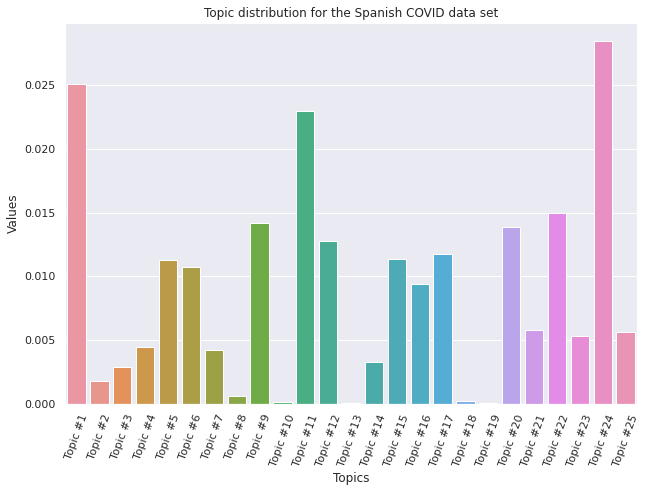

In [ ]:

sns.set(rc={'figure.figsize':(10.25, 7)})
sns_plot = sns.barplot(x="Topics", y="Values", data=df_topic_distribution_spanish_covid[:25]).set_title('Topic distribution for the Spanish COVID data set')
plt.xticks(rotation=70)

fig = sns_plot.get_figure()
fig.savefig('{name}.png'.format(name = 'topic_dist_spanish_covid'), dpi=150)
plt.show()

**Topic distribution for English tweets**

In [ ]:
english_topic_distribution = read_words_in_topics(lda_english_path_result + '/TopicsDistributionOnUsers.txt')

In [ ]:
dist_english_palma = english_topic_distribution[0]
values_dist_english_palma = [float(value) for value in dist_english_palma[1:]]

topics = ['Topic #{n}'.format(n = i+1) for i in range(len(values_dist_english_palma))]
df_topic_distribution_english_palma = pd.DataFrame(data = {'Topics': topics, 'Values': values_dist_english_palma})

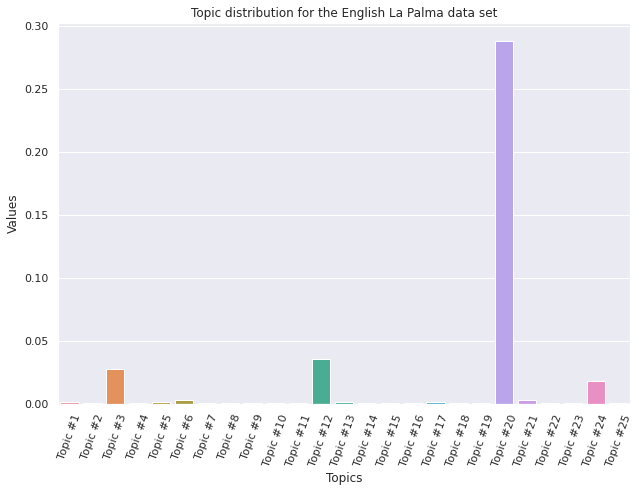

In [ ]:
sns.set(rc={'figure.figsize':(10.25, 7)})
sns_plot = sns.barplot(x="Topics", y="Values", data=df_topic_distribution_english_palma[:25]).set_title('Topic distribution for the English La Palma data set')
plt.xticks(rotation=70)

fig = sns_plot.get_figure()
fig.savefig('{name}.png'.format(name = 'topic_dist_english_palma'), dpi=150)
plt.show()

In [ ]:
dist_english_covid = english_topic_distribution[1]
values_dist_english_covid = [float(value) for value in dist_english_covid[1:]]

topics = ['Topic #{n}'.format(n = i+1) for i in range(len(values_dist_english_covid))]
df_topic_distribution_english_covid = pd.DataFrame(data = {'Topics': topics, 'Values': values_dist_english_covid})

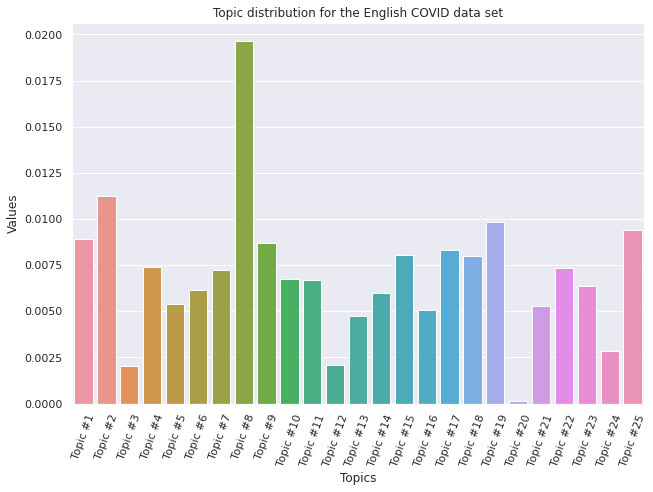

In [ ]:
sns.set(rc={'figure.figsize':(10.25, 7)})
sns_plot = sns.barplot(x="Topics", y="Values", data=df_topic_distribution_english_covid[:25]).set_title('Topic distribution for the English COVID data set')
plt.xticks(rotation=70)

fig = sns_plot.get_figure()
fig.savefig('{name}.png'.format(name = 'topic_dist_english_covid'), dpi=150)
plt.show()

Now, we mix the COVID data set regardless the language. I.e, we plot topic distribution for the COVID and La Palma data set regardless the language.

In [ ]:
df_topic_distribution_covid = pd.DataFrame()
df_topic_distribution_covid['Topics'] = df_topic_distribution_english_covid['Topics']
df_topic_distribution_covid['Spanish weights'] = df_topic_distribution_spanish_covid['Values']
df_topic_distribution_covid['English weights'] = df_topic_distribution_english_covid['Values']

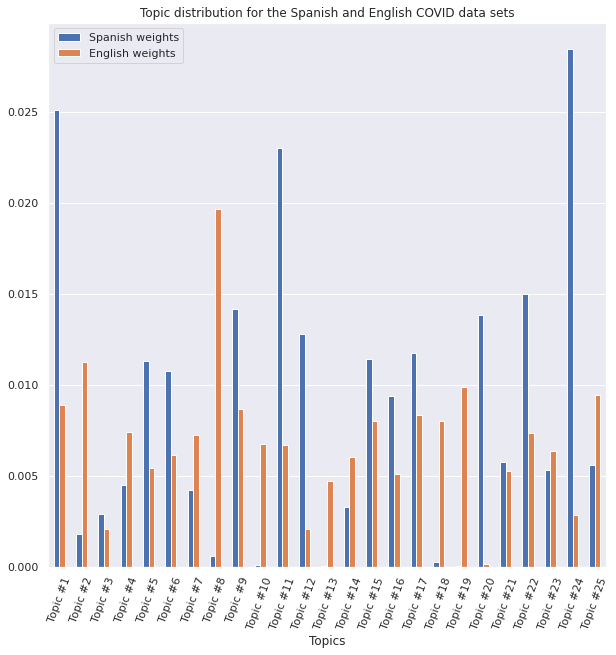

In [ ]:

sns_topic_dist_covid = df_topic_distribution_covid.set_index('Topics')[:25].plot.bar( figsize=(10, 10))
sns_topic_dist_covid.grid(axis='x')
sns_topic_dist_covid.set_title('Topic distribution for the Spanish and English COVID data sets')
plt.xticks(rotation=70)

fig = sns_topic_dist_covid.get_figure()
fig.savefig('{name}.png'.format(name = 'topic_dist_covid'), dpi=150)
plt.show()

In [ ]:
df_topic_distribution_palma = pd.DataFrame()
df_topic_distribution_palma['Topics'] = df_topic_distribution_english_palma['Topics']
df_topic_distribution_palma['Spanish weights'] = df_topic_distribution_spanish_palma['Values']
df_topic_distribution_palma['English weights'] = df_topic_distribution_english_palma['Values']

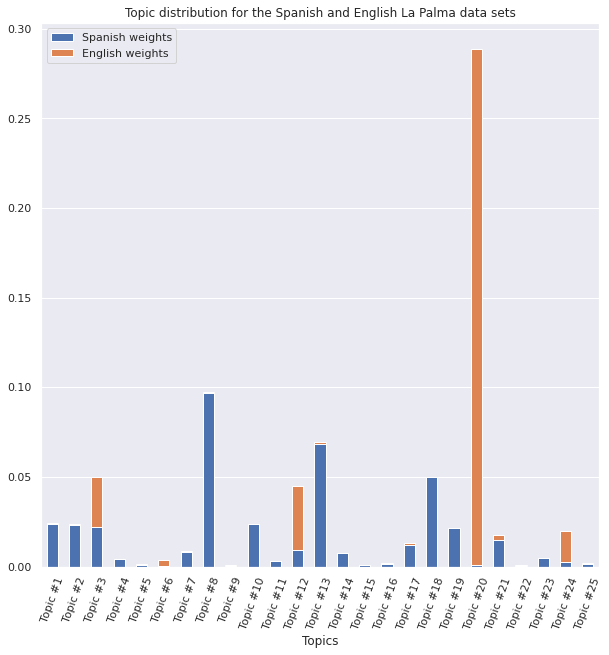

In [ ]:

sns_topic_dist_palma = df_topic_distribution_palma.set_index('Topics')[:25].plot.bar(stacked=True, figsize=(10, 10))
sns_topic_dist_palma.grid(axis='x')
sns_topic_dist_palma.set_title('Topic distribution for the Spanish and English La Palma data sets')
plt.xticks(rotation=70)
fig = sns_topic_dist_palma.get_figure()
fig.savefig('{name}.png'.format(name = 'topic_dist_palma'), dpi=150)
plt.show()

# 4. Clustering of tweets

For the clustering task it will be used the CLUTO tool since it provides multiple clustering methods and it is intended to support high dimensional data sets. <br>
Regarding the TF-IDF matrices computed in the section 1.1.2 and the `.mat` files from these matrices, it will be executed a set of experiments to measure the clustering quality.

## 4.1 CLUTO commands: creation and execution

Firstly, it will be downloaded the tool

In [ ]:
!wget http://glaros.dtc.umn.edu/gkhome/fetch/sw/cluto/cluto-2.1.1.zip
!unzip cluto-2.1.1.zip
!chmod u+x /content/cluto-2.1.1/Linux/vcluster

--2022-03-22 18:05:40--  http://glaros.dtc.umn.edu/gkhome/fetch/sw/cluto/cluto-2.1.1.zip
Resolving glaros.dtc.umn.edu (glaros.dtc.umn.edu)... 160.94.40.33
Connecting to glaros.dtc.umn.edu (glaros.dtc.umn.edu)|160.94.40.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9359277 (8.9M) [application/zip]
Saving to: ‘cluto-2.1.1.zip’

cluto-2.1.1.zip     100%[===================>]   8.92M  5.59MB/s    in 1.6s    

2022-03-22 18:05:42 (5.59 MB/s) - ‘cluto-2.1.1.zip’ saved [9359277/9359277]

Archive:  cluto-2.1.1.zip
   creating: cluto-2.1.1/
  inflating: cluto-2.1.1/CHANGES     
  inflating: cluto-2.1.1/cluto.h     
  inflating: cluto-2.1.1/COPYRIGHT   
   creating: cluto-2.1.1/Linux/
  inflating: cluto-2.1.1/Linux/libcluto.a  
  inflating: cluto-2.1.1/Linux/scluster  
  inflating: cluto-2.1.1/Linux/vcluster  
  inflating: cluto-2.1.1/manual.pdf  
  inflating: cluto-2.1.1/manual.ps   
   creating: cluto-2.1.1/Matrices/
  inflating: cluto-2.1.1/Matrices/genes1.mat  


The next functions will help to create the cluto command with the `vcluster` program.

In [ ]:
def params_to_string(param_dict: dict) -> str:

  param_string = ""

  params = []
  for key, value in param_dict.items():
    string_param = "-" + key + "=" + value
    params.append(string_param)

  return params


def get_cluto_command(clusterer, n_clusters, document_matrix_path, params) -> list:
  stringfied_params = params_to_string(params)
  stringfied_params.insert(0, clusterer)
  stringfied_params.append(document_matrix_path)
  stringfied_params.append(str(n_clusters))
  return stringfied_params

Next, it will be defined the parameters for the commands. Two clustering algorithms are considered: `rbr` and `agglo`. The similarity function is the cosine between two vectors and the criterion function is the `h1`. <br>
On the other hand, the experiments will only consist in tweaking the number of clusters.

In [ ]:
params_cluto = {
    "cluster_methods": ["rbr", "graph"],#["rbr", "agglo"],
    "similarities": ["cos"],
    "criterion_functions": ["i2"],
    # "num_clusters": [5, 6, 7, 10, 13],
    "datasets": ["covid_en", "covid_es", "la_palma_en", "la_palma_es"],

    "matrices": {
             # Normalized TF-IDF
             "covid_en_norm": "/content/tfIdfMatrices/normalized/covid/tfidf_english_covid.mat", #Done
             "covid_es_norm": "/content/tfIdfMatrices/normalized/covid/tfidf_spanish_covid.mat", #Done

             "la_palma_en_norm": "/content/tfIdfMatrices/normalized/palma/tfidf_english_palma.mat", #Done
             "la_palma_es_norm": "/content/tfIdfMatrices/normalized/palma/tfidf_spanish_palma.mat", #Done

             # Raw TF-IDF
             "covid_en_raw": "/content/tfIdfMatrices/raw/covid/tfidf_english_covid.mat", #Done 5h, 30min
             "covid_es_raw": "/content/tfIdfMatrices/raw/covid/tfidf_spanish_covid.mat",

             "la_palma_en_raw": "/content/tfIdfMatrices/raw/palma/tfidf_english_palma.mat",
             "la_palma_es_raw": "/content/tfIdfMatrices/raw/palma/tfidf_spanish_palma.mat"
    }

}

Next, the CLUTO commands will be executed regarding the `params_cluto`. The CLUTO outputs will be stored in the folder `clutoResults`.

In [ ]:
!mkdir clutoResults

In [ ]:
from datetime import datetime
import subprocess
import time

In [ ]:
import subprocess
import time
c_methods = params_cluto['cluster_methods']
similarities = params_cluto['similarities']
crit_functions = params_cluto['criterion_functions']
# num_clusters = params_cluto['num_clusters']

cluto_commands = dict()
filenames = []
total_time_cluto_commands = time.time()
for dataset in params_cluto['matrices'].keys():
  for method in c_methods:
    for sim in similarities:
      for function in crit_functions:
        for n_clusters in range(10, 90, 5):
          params = {
              "clmethod": method,
              "sim": sim,
              "crfun": function
          }
          cluto_command = get_cluto_command(
              args_loading.vcluster_path,
              n_clusters,
              params_cluto['matrices'][dataset],
              params
          )
          result_path = "clutoResults/{dataset_result}".format(dataset_result = dataset)
          subprocess.run(["mkdir", result_path])
          file_name = dataset + "_" + method + "_" + function + "_" + sim + "_" + str(n_clusters)
          cluto_commands[file_name] = cluto_command
          print("{date}: Executing {config_cluto}".format(config_cluto = " ".join(cluto_command), date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")))
          cluto_command_start_time = time.time()
          output_file_name = file_name + ".clustering" 

          cluto_command.append("-clustfile=" + result_path + "/" + output_file_name)
          with open( result_path + "/" + file_name + ".txt", "w") as f:
              subprocess.run(cluto_command, stdout=f)
          print('CLUTO command {cluto_command}'.format(cluto_command=" ".join(cluto_command)) +  ' executed. Elapsed time:  {:.2f}s'.format(time.time() - cluto_command_start_time))
          print()
    print("FINISHED METHOD {method}".format(method = method))

print("TOTAL ELAPSED TIME IN EXECUTING ALL CLUTO COMMANDS: {:.2f}".format(time.time() - total_time_cluto_commands))

20/03/2022 09:21:28: Executing /content/cluto-2.1.1/Linux/vcluster -clmethod=rbr -sim=cos -crfun=i2 /content/tfIdfMatrices/raw/covid/tfidf_spanish_covid.mat 10
CLUTO command /content/cluto-2.1.1/Linux/vcluster -clmethod=rbr -sim=cos -crfun=i2 /content/tfIdfMatrices/raw/covid/tfidf_spanish_covid.mat 10 -clustfile=clutoResults/covid_es_raw/covid_es_raw_rbr_i2_cos_10.clustering executed. Elapsed time:  10.87s

20/03/2022 09:21:39: Executing /content/cluto-2.1.1/Linux/vcluster -clmethod=rbr -sim=cos -crfun=i2 /content/tfIdfMatrices/raw/covid/tfidf_spanish_covid.mat 15
CLUTO command /content/cluto-2.1.1/Linux/vcluster -clmethod=rbr -sim=cos -crfun=i2 /content/tfIdfMatrices/raw/covid/tfidf_spanish_covid.mat 15 -clustfile=clutoResults/covid_es_raw/covid_es_raw_rbr_i2_cos_15.clustering executed. Elapsed time:  12.64s

20/03/2022 09:21:52: Executing /content/cluto-2.1.1/Linux/vcluster -clmethod=rbr -sim=cos -crfun=i2 /content/tfIdfMatrices/raw/covid/tfidf_spanish_covid.mat 20
CLUTO command /con

Next, we process all the CLUTO outputs

TODO: Load the outputs from Google drive

ls: cannot access '/drive': No such file or directory


In [ ]:
def process_numerics(numeric_data: list) -> list:

  numbers = [ numeric_line.strip().split() for numeric_line in numeric_data]

  result = []
  for line in numbers:
    formatted_line = []
    
    for number in line[:len(line) - 1]:  # delete the vertical slash from the lsit value
      formatted = number
      if number.startswith('+') or number.startswith('-'):
        formatted = number[1:]
    
      formatted_line.append(float(formatted))
    
    result.append(formatted_line)
  
  return result

def process_cluto_output(file_path):
  
  splitted_path = file_path.split("/")

  name = splitted_path[len(splitted_path)-1]
  numerics_processed = []
  with open(file_path, 'r') as file_r:
    lines = file_r.readlines()

    numeric_data_with_end = lines[19:]
    numeric_data = numeric_data_with_end[: len(numeric_data_with_end) - 7]

    numerics_processed = process_numerics(numeric_data)

  return {
      'file_name': name,
      'numerical_data': numerics_processed
  }

def build_cluto_dataframe(numerics, columns = args_loading.cluto_columns):

  df = pd.DataFrame(columns=columns)

  index = 0
  for numerical_data in numerics:

    values_to_add = {'Cluster id': str(int(numerical_data[0])),
                    'Size': int(numerical_data[1]),
                    'ISim': numerical_data[2],
                    'ISdev': numerical_data[3],
                    'ESim': numerical_data[4],
                    'ESdev': numerical_data[5]}

    row_to_add = pd.Series(values_to_add, name=index)
    index += 1

    df = df.append(row_to_add)

  df = df.astype({'Cluster id':'str', 'Size': 'int'})

  return df

Next, we store each CLUTO output in Dataframes

In [ ]:
import os
output_base_path = "/content/drive/MyDrive/clutoFinal{}"

In [ ]:
datasets = os.listdir(output_base_path.format(""))

output_cluto_per_dataset = dict()
for dataset in datasets:
  path_dataset = output_base_path.format("/" + dataset)
  cluto_outputs_file_names = [ output_file_name  for output_file_name in os.listdir(path_dataset) if output_file_name.endswith(".txt")]

  cluto_outputs = []
  for cluto_output_file in cluto_outputs_file_names:
    cluto_output_parsed = process_cluto_output(path_dataset + "/" + cluto_output_file)
    cluto_outputs.append(cluto_output_parsed)
  output_cluto_per_dataset[dataset] = cluto_outputs

In [ ]:
output_cluto_per_dataset.keys()

dict_keys(['covid_en_norm', 'covid_es_norm', 'la_palma_en_norm', 'la_palma_es_norm', 'covid_en_raw', 'covid_es_raw', 'la_palma_en_raw', 'la_palma_es_raw'])

## Analysing cluster quality via ISim and ESim

## Question: Is there any differences in the ISim and ESim metrics regarding the type of preprocessing applied? I.e Does the preprocessing affect drastically the cluster queality?

For each language and dataset, plot the ISim and ESim curves.

In [ ]:
def plot_cluster_metric(output_cluto_per_dataset,
                         dataset_name, #covid or la_palma
                         lang,
                        #  process,# or norm/raw
                         n_clusters,
                         metric,
                         axes,
                         index_axis): # ISim or ESim (or their standard deviations)
  query_retrieve_outputs = "{dataset_name}_{lang}_{process}"
  dataset_en_norm = output_cluto_per_dataset[query_retrieve_outputs.format(dataset_name = dataset_name,
                                                                         lang = lang,
                                                                         process='norm')]
  dataset_en_raw = output_cluto_per_dataset[query_retrieve_outputs.format(dataset_name=dataset_name,
                                                                        lang=lang,
                                                                        process='raw')]

  algorithm = 'rbr'
  dataset_en_norm_rbr = [output for output in dataset_en_norm if algorithm in output['file_name'] and str(n_clusters) in output['file_name']]
  dataset_en_raw_rbr = [output for output in dataset_en_raw if algorithm in output['file_name'] and str(n_clusters) in output['file_name']]

  algorithm = 'graph'
  dataset_en_norm_graph = [output for output in dataset_en_norm if algorithm in output['file_name'] and str(n_clusters) in output['file_name']]
  dataset_en_raw_graph = [output for output in dataset_en_raw if algorithm in output['file_name'] and str(n_clusters) in output['file_name']]

  df_dataset_en_norm_rbr = build_cluto_dataframe(dataset_en_norm_rbr[0]['numerical_data']) #covid_en_norm_rbr_85 
  df_dataset_en_raw_rbr = build_cluto_dataframe(dataset_en_raw_rbr[0]['numerical_data'])

  df_dataset_en_norm_graph = build_cluto_dataframe(dataset_en_norm_graph[0]['numerical_data']) #covid_en_norm_rbr_85 
  df_dataset_en_raw_graph = build_cluto_dataframe(dataset_en_raw_graph[0]['numerical_data'])


  # build the dataframe 

  df_metric_dataset_en_rbr = pd.DataFrame()
  df_metric_dataset_en_rbr['Cluster id'] = df_dataset_en_norm_rbr['Cluster id']
  df_metric_dataset_en_rbr['RBR {metric} Processed'.format(metric = metric)] = df_dataset_en_norm_rbr[metric] # metric = ISim e.g
  df_metric_dataset_en_rbr['RBR {metric} Raw'.format(metric = metric)] = df_dataset_en_raw_rbr[metric]

  df_metric_dataset_en_rbr['Graph {metric} Processed'.format(metric = metric)] = df_dataset_en_norm_graph[metric]
  df_metric_dataset_en_rbr['Graph {metric} Raw'.format(metric = metric)] = df_dataset_en_raw_graph[metric]

  df_metric_dataset_en_rbr = df_metric_dataset_en_rbr.set_index('Cluster id')

  sns.set(rc={'figure.figsize':(15,5)})
  ax = sns.lineplot(ax=axes[index_axis], data=df_metric_dataset_en_rbr)


  return ax, df_metric_dataset_en_rbr.reset_index()

### $ISim$ and $ISdev$ curves for `covid` dataset

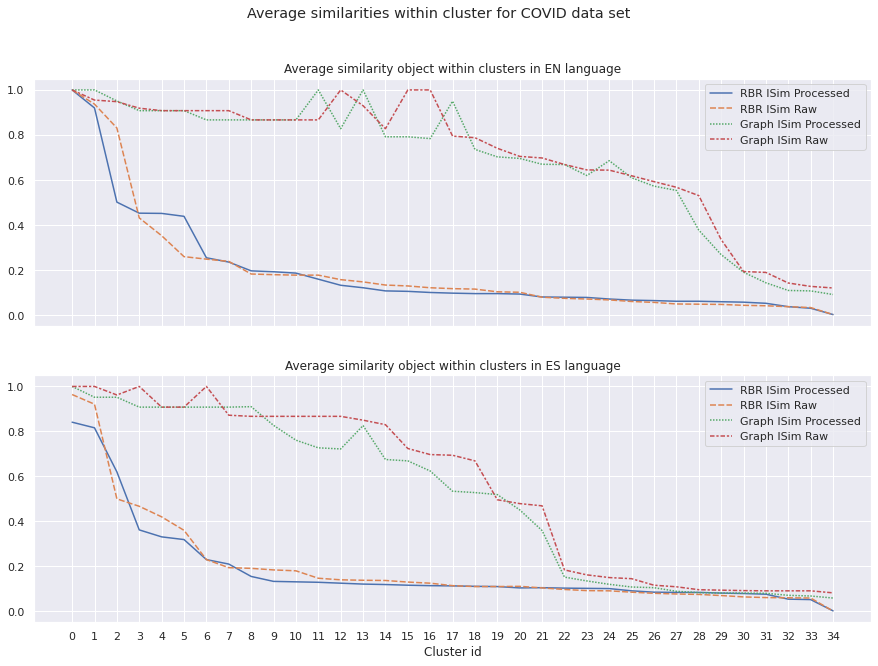

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,10))
index_axis = 0

dataset_name = 'covid'
lang = 'en'
n_clusters = 35
metric = 'ISim'

fig.suptitle('Average similarities within cluster for COVID data set')
ax, df_palma_en_35_isim = plot_cluster_metric(
    output_cluto_per_dataset,
    dataset_name,
    lang,
    n_clusters,
    metric,
    axes,
    index_axis
)
axes[index_axis].set_title('Average similarity object within clusters in {lang} language'.format(
      metric = metric,
      lang = lang.upper(),    
))

index_axis += 1
lang = 'es'

ax, df_palma_es_35_isim = plot_cluster_metric(
    output_cluto_per_dataset,
    dataset_name,
    lang,
    n_clusters,
    metric,
    axes,
    index_axis
)

axes[index_axis].set_title('Average similarity object within clusters in {lang} language'.format(
      metric = metric,
      lang = lang.upper(),    
))
   
fig.savefig('{name}.png'.format(name = 'ISim_clusters_covid_en_es'), dpi=150)

ISdev curves

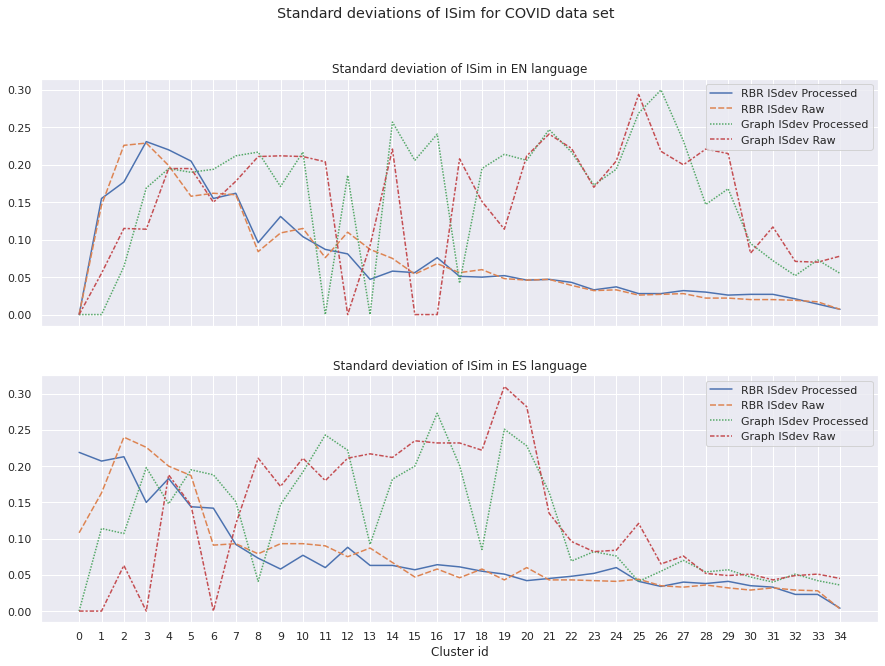

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,10))
index_axis = 0

dataset_name = 'covid'
lang = 'en'
n_clusters = 35
metric = 'ISdev'

fig.suptitle('Standard deviations of ISim for COVID data set')
ax, df_palma_en_35_isim = plot_cluster_metric(
    output_cluto_per_dataset,
    dataset_name,
    lang,
    n_clusters,
    metric,
    axes,
    index_axis
)

axes[index_axis].set_title('Standard deviation of ISim in {lang} language'.format(
      metric = metric,
      lang = lang.upper(),    
))

index_axis += 1
lang = 'es'
ax, df_palma_es_35_isim = plot_cluster_metric(
    output_cluto_per_dataset,
    dataset_name,
    lang,
    n_clusters,
    metric,
    axes,
    index_axis
)

axes[index_axis].set_title('Standard deviation of ISim in {lang} language'.format(
      metric = metric,
      lang = lang.upper(),    
))

fig.savefig('{name}.png'.format(name = 'ISdev_clusters_covid_en_es'), dpi=150)

### $ESim$ curves for `covid` dataset

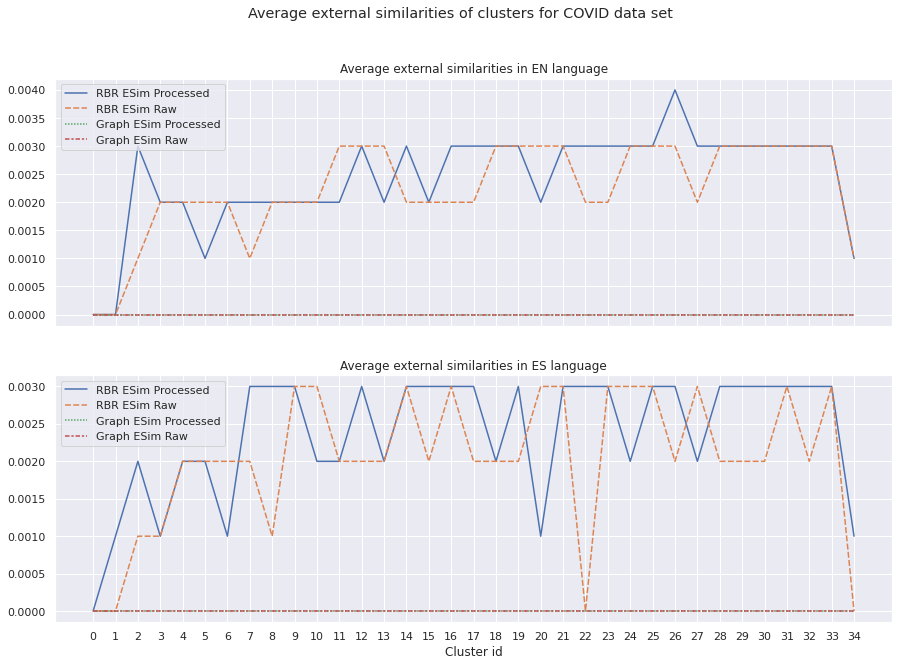

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,10))
index_axis = 0

dataset_name = 'covid'
lang = 'en'
n_clusters = 35
metric = 'ESim'

fig.suptitle('Average external similarities of clusters for COVID data set')
ax, df_palma_en_35_isim = plot_cluster_metric(
    output_cluto_per_dataset,
    dataset_name,
    lang,
    n_clusters,
    metric,
    axes,
    index_axis
)

axes[index_axis].set_title('Average external similarities in {lang} language'.format(
      metric = metric,
      lang = lang.upper(),    
))

index_axis += 1
lang = 'es'
ax, df_palma_es_35_isim = plot_cluster_metric(
    output_cluto_per_dataset,
    dataset_name,
    lang,
    n_clusters,
    metric,
    axes,
    index_axis
)

axes[index_axis].set_title('Average external similarities in {lang} language'.format(
      metric = metric,
      lang = lang.upper(),    
))
fig.savefig('{name}.png'.format(name = 'ESim_clusters_covid_en_es'), dpi=150)

### $ISim$ and $ISdev$ curves for `la_palma` dataset

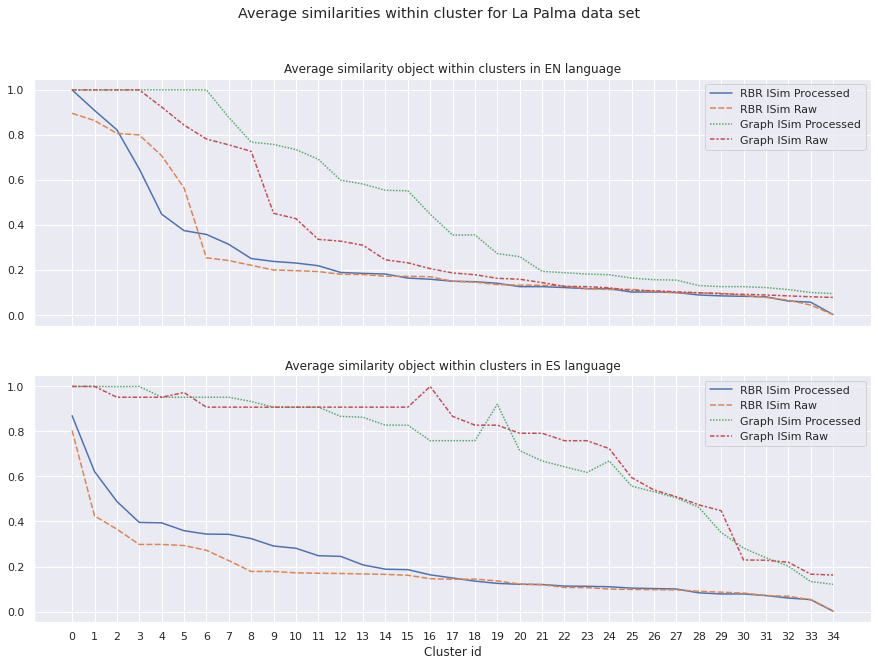

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,10))
index_axis = 0

dataset_name = 'la_palma'
lang = 'en'
n_clusters = 35
metric = 'ISim'

fig.suptitle('Average similarities within cluster for La Palma data set')
ax, df_palma_en_35_isim = plot_cluster_metric(
    output_cluto_per_dataset,
    dataset_name,
    lang,
    n_clusters,
    metric,
    axes,
    index_axis
)
axes[index_axis].set_title('Average similarity object within clusters in {lang} language'.format(
      metric = metric,
      lang = lang.upper(),    
))

index_axis += 1
lang = 'es'
ax, df_palma_es_35_isim = plot_cluster_metric(
    output_cluto_per_dataset,
    dataset_name,
    lang,
    n_clusters,
    metric,
    axes,
    index_axis
)
axes[index_axis].set_title('Average similarity object within clusters in {lang} language'.format(
      metric = metric,
      lang = lang.upper(),    
))

fig.savefig('{name}.png'.format(name = 'ISim_clusters_la_palma_en_es'), dpi=150)

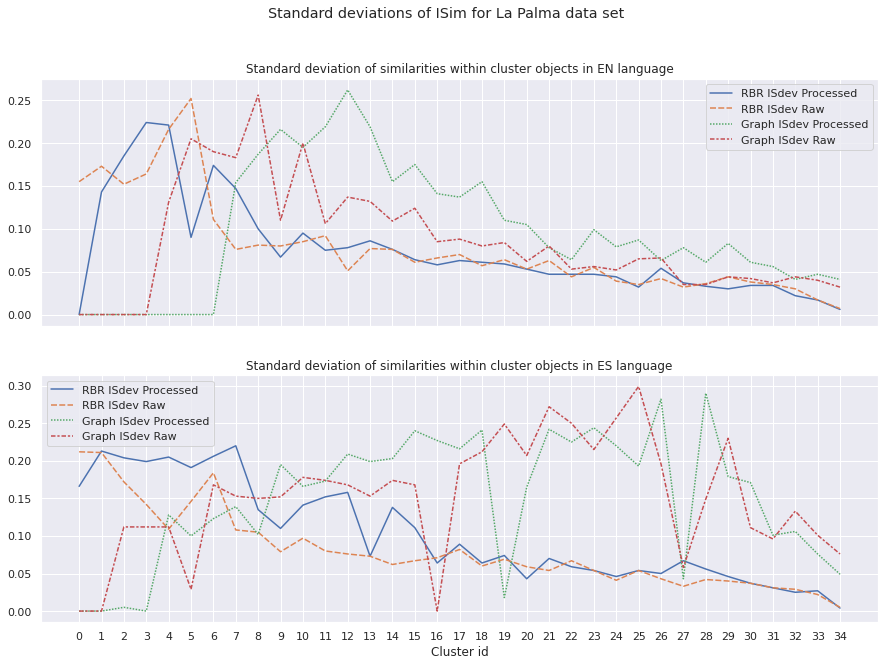

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,10))
index_axis = 0

dataset_name = 'la_palma'
lang = 'en'
n_clusters = 35
metric = 'ISdev'

fig.suptitle('Standard deviations of ISim for La Palma data set')
ax, df_palma_en_35_isim = plot_cluster_metric(
    output_cluto_per_dataset,
    dataset_name,
    lang,
    n_clusters,
    metric,
    axes,
    index_axis
)
axes[index_axis].set_title('Standard deviation of similarities within cluster objects in {lang} language'.format(
      metric = metric,
      lang = lang.upper(),    
))

index_axis += 1
lang = 'es'
ax, df_palma_es_35_isim = plot_cluster_metric(
    output_cluto_per_dataset,
    dataset_name,
    lang,
    n_clusters,
    metric,
    axes,
    index_axis
)
axes[index_axis].set_title('Standard deviation of similarities within cluster objects in {lang} language'.format(
      metric = metric,
      lang = lang.upper(),    
))

fig.savefig('{name}.png'.format(name = 'ISdev_clusters_la_palma_en_es'), dpi=150)

### $ESim$ curves for `la_palma` dataset

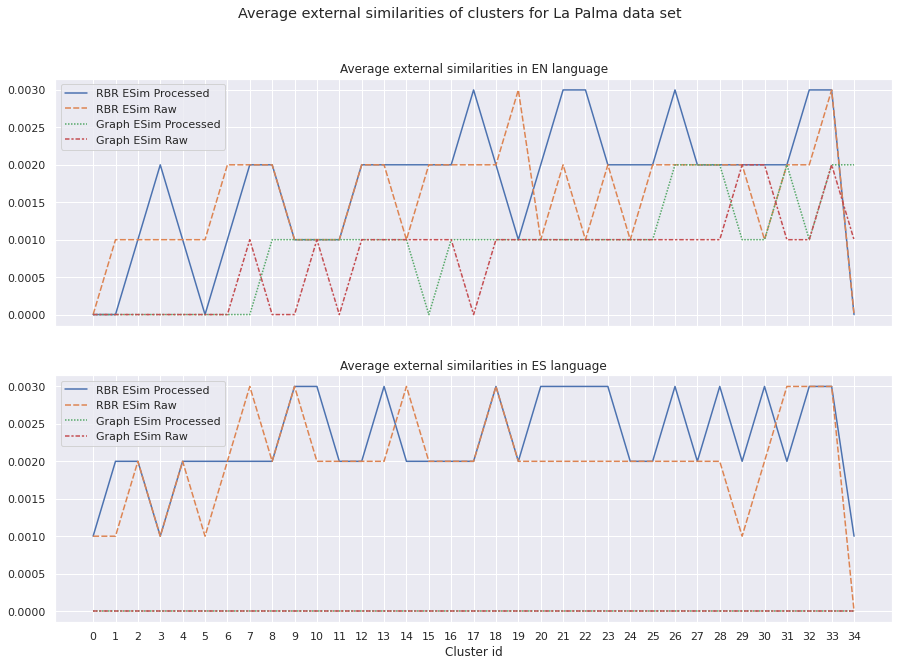

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,10))
index_axis = 0

dataset_name = 'la_palma'
lang = 'en'
n_clusters = 35
metric = 'ESim'

fig.suptitle('Average external similarities of clusters for La Palma data set')
ax, df_palma_en_35_isim = plot_cluster_metric(
    output_cluto_per_dataset,
    dataset_name,
    lang,
    n_clusters,
    metric,
    axes,
    index_axis
)
axes[index_axis].set_title('Average external similarities in {lang} language'.format(
      metric = metric,
      lang = lang.upper(),    
))

index_axis += 1
lang = 'es'
ax, df_palma_es_35_isim = plot_cluster_metric(
    output_cluto_per_dataset,
    dataset_name,
    lang,
    n_clusters,
    metric,
    axes,
    index_axis
)
axes[index_axis].set_title('Average external similarities in {lang} language'.format(
      metric = metric,
      lang = lang.upper(),    
))

fig.savefig('{name}.png'.format(name = 'ESim_clusters_la_palma_en_es'), dpi=150)